# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6120345225736834 -3.261442747386232
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.nn.sigmoid(Qs_label)))    
    return actions_logits, Qs_logits, g_loss, d_loss

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        #for step in (111111111111):
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                resulting_reward = total_reward/500 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        #print(targetQs.shape)
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt], 
                             feed_dict = {model.states: states, 
                                          model.actions: actions,
                                          model.reward: resulting_reward, 
                                          model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode: {}'.format(ep),
              'mean_episodes_total_reward: {:.4f}'.format(np.mean(episodes_total_reward)),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode: 0 mean_episodes_total_reward: 9.0000 g_loss: 0.6756 d_loss: 0.7865
Episode: 1 mean_episodes_total_reward: 9.0000 g_loss: 0.6861 d_loss: 0.7447
Episode: 2 mean_episodes_total_reward: 9.3333 g_loss: 0.6950 d_loss: 0.7077
Episode: 3 mean_episodes_total_reward: 9.5000 g_loss: 0.7029 d_loss: 0.6689
Episode: 4 mean_episodes_total_reward: 9.4000 g_loss: 0.7082 d_loss: 0.6368
Episode: 5 mean_episodes_total_reward: 9.3333 g_loss: 0.7130 d_loss: 0.6022
Episode: 6 mean_episodes_total_reward: 9.2857 g_loss: 0.7160 d_loss: 0.5712
Episode: 7 mean_episodes_total_reward: 9.2500 g_loss: 0.7174 d_loss: 0.5425
Episode: 8 mean_episodes_total_reward: 9.3333 g_loss: 0.7157 d_loss: 0.5000
Episode: 9 mean_episodes_total_reward: 9.3000 g_loss: 0.7157 d_loss: 0.4883
Episode: 10 mean_episodes_total_reward: 9.2727 g_loss: 0.7124 d_loss: 0.4607
Episode: 11 mean_episodes_total_reward: 9.2500 g_loss: 0.7080 d_loss: 0.4369
Episode: 12 mean_episodes_total_reward: 9.3077 g_loss: 0.6962 d_loss: 0.4068
Episode: 

Episode: 106 mean_episodes_total_reward: 16.7800 g_loss: 0.1402 d_loss: 0.1825
Episode: 107 mean_episodes_total_reward: 16.8700 g_loss: 0.1801 d_loss: 0.1557
Episode: 108 mean_episodes_total_reward: 17.0000 g_loss: 0.1439 d_loss: 0.1889
Episode: 109 mean_episodes_total_reward: 17.0700 g_loss: 0.2108 d_loss: 0.1430
Episode: 110 mean_episodes_total_reward: 17.1400 g_loss: 0.2042 d_loss: 0.1430
Episode: 111 mean_episodes_total_reward: 17.1800 g_loss: 0.2437 d_loss: 0.1234
Episode: 112 mean_episodes_total_reward: 17.2100 g_loss: 0.2543 d_loss: 0.1242
Episode: 113 mean_episodes_total_reward: 17.2200 g_loss: 0.2918 d_loss: 0.1100
Episode: 114 mean_episodes_total_reward: 17.2200 g_loss: 0.3498 d_loss: 0.0971
Episode: 115 mean_episodes_total_reward: 17.2300 g_loss: 0.3041 d_loss: 0.1116
Episode: 116 mean_episodes_total_reward: 17.2500 g_loss: 0.3224 d_loss: 0.1052
Episode: 117 mean_episodes_total_reward: 17.2500 g_loss: 0.3758 d_loss: 0.0979
Episode: 118 mean_episodes_total_reward: 17.2400 g_l

Episode: 211 mean_episodes_total_reward: 16.4900 g_loss: 0.2449 d_loss: 0.1382
Episode: 212 mean_episodes_total_reward: 16.6300 g_loss: 0.1625 d_loss: 0.2115
Episode: 213 mean_episodes_total_reward: 16.7700 g_loss: 0.1658 d_loss: 0.1996
Episode: 214 mean_episodes_total_reward: 17.0700 g_loss: 0.0898 d_loss: 0.2836
Episode: 215 mean_episodes_total_reward: 17.1000 g_loss: 0.2491 d_loss: 0.1313
Episode: 216 mean_episodes_total_reward: 17.1700 g_loss: 0.2057 d_loss: 0.1492
Episode: 217 mean_episodes_total_reward: 17.2700 g_loss: 0.1862 d_loss: 0.1619
Episode: 218 mean_episodes_total_reward: 17.3800 g_loss: 0.1725 d_loss: 0.1684
Episode: 219 mean_episodes_total_reward: 17.4800 g_loss: 0.1641 d_loss: 0.1684
Episode: 220 mean_episodes_total_reward: 17.5200 g_loss: 0.2432 d_loss: 0.1225
Episode: 221 mean_episodes_total_reward: 17.6000 g_loss: 0.1882 d_loss: 0.1487
Episode: 222 mean_episodes_total_reward: 17.6400 g_loss: 0.2096 d_loss: 0.1354
Episode: 223 mean_episodes_total_reward: 17.6200 g_l

Episode: 319 mean_episodes_total_reward: 23.2400 g_loss: 0.2594 d_loss: 0.1549
Episode: 320 mean_episodes_total_reward: 23.2400 g_loss: 0.2939 d_loss: 0.1316
Episode: 321 mean_episodes_total_reward: 23.2100 g_loss: 0.2819 d_loss: 0.1369
Episode: 322 mean_episodes_total_reward: 23.1900 g_loss: 0.2880 d_loss: 0.1296
Episode: 323 mean_episodes_total_reward: 23.1800 g_loss: 0.3412 d_loss: 0.1112
Episode: 324 mean_episodes_total_reward: 23.1500 g_loss: 0.3388 d_loss: 0.1105
Episode: 325 mean_episodes_total_reward: 23.1100 g_loss: 0.3013 d_loss: 0.1153
Episode: 326 mean_episodes_total_reward: 23.1100 g_loss: 0.3211 d_loss: 0.1071
Episode: 327 mean_episodes_total_reward: 23.0600 g_loss: 0.2789 d_loss: 0.1191
Episode: 328 mean_episodes_total_reward: 22.8400 g_loss: 0.2676 d_loss: 0.1250
Episode: 329 mean_episodes_total_reward: 22.8500 g_loss: 0.2981 d_loss: 0.1112
Episode: 330 mean_episodes_total_reward: 22.3900 g_loss: 0.2931 d_loss: 0.1124
Episode: 331 mean_episodes_total_reward: 22.2400 g_l

Episode: 426 mean_episodes_total_reward: 22.5600 g_loss: 0.2758 d_loss: 0.1363
Episode: 427 mean_episodes_total_reward: 22.5700 g_loss: 0.2821 d_loss: 0.1297
Episode: 428 mean_episodes_total_reward: 22.6100 g_loss: 0.2426 d_loss: 0.1532
Episode: 429 mean_episodes_total_reward: 22.7100 g_loss: 0.2223 d_loss: 0.1773
Episode: 430 mean_episodes_total_reward: 22.9300 g_loss: 0.1654 d_loss: 0.2450
Episode: 431 mean_episodes_total_reward: 23.4200 g_loss: 0.0371 d_loss: 0.4165
Episode: 432 mean_episodes_total_reward: 23.8600 g_loss: 0.0795 d_loss: 0.3538
Episode: 433 mean_episodes_total_reward: 24.2600 g_loss: 0.0955 d_loss: 0.3395
Episode: 434 mean_episodes_total_reward: 24.6600 g_loss: 0.0833 d_loss: 0.3526
Episode: 435 mean_episodes_total_reward: 24.7400 g_loss: 0.2663 d_loss: 0.1639
Episode: 436 mean_episodes_total_reward: 24.7900 g_loss: 0.2374 d_loss: 0.1785
Episode: 437 mean_episodes_total_reward: 24.9200 g_loss: 0.2125 d_loss: 0.1884
Episode: 438 mean_episodes_total_reward: 24.9200 g_l

Episode: 532 mean_episodes_total_reward: 19.8300 g_loss: 0.1821 d_loss: 0.2069
Episode: 533 mean_episodes_total_reward: 19.4500 g_loss: 0.2882 d_loss: 0.1203
Episode: 534 mean_episodes_total_reward: 20.3200 g_loss: -0.2592 d_loss: 0.8308
Episode: 535 mean_episodes_total_reward: 20.3400 g_loss: 0.2528 d_loss: 0.1745
Episode: 536 mean_episodes_total_reward: 20.2700 g_loss: 0.2986 d_loss: 0.1412
Episode: 537 mean_episodes_total_reward: 20.2400 g_loss: 0.2298 d_loss: 0.1720
Episode: 538 mean_episodes_total_reward: 20.2300 g_loss: 0.2977 d_loss: 0.1411
Episode: 539 mean_episodes_total_reward: 20.2900 g_loss: 0.2508 d_loss: 0.1612
Episode: 540 mean_episodes_total_reward: 20.3100 g_loss: 0.2735 d_loss: 0.1378
Episode: 541 mean_episodes_total_reward: 20.2900 g_loss: 0.3109 d_loss: 0.1212
Episode: 542 mean_episodes_total_reward: 20.3300 g_loss: 0.2452 d_loss: 0.1415
Episode: 543 mean_episodes_total_reward: 20.3400 g_loss: 0.2404 d_loss: 0.1407
Episode: 544 mean_episodes_total_reward: 20.3900 g_

Episode: 639 mean_episodes_total_reward: 21.2600 g_loss: -0.0069 d_loss: 0.4371
Episode: 640 mean_episodes_total_reward: 21.6700 g_loss: 0.0295 d_loss: 0.3750
Episode: 641 mean_episodes_total_reward: 21.8100 g_loss: 0.1699 d_loss: 0.1991
Episode: 642 mean_episodes_total_reward: 21.9500 g_loss: 0.1508 d_loss: 0.2226
Episode: 643 mean_episodes_total_reward: 22.0300 g_loss: 0.1837 d_loss: 0.1872
Episode: 644 mean_episodes_total_reward: 22.0600 g_loss: 0.2094 d_loss: 0.1564
Episode: 645 mean_episodes_total_reward: 22.1500 g_loss: 0.2127 d_loss: 0.1630
Episode: 646 mean_episodes_total_reward: 22.1100 g_loss: 0.3031 d_loss: 0.1132
Episode: 647 mean_episodes_total_reward: 22.1400 g_loss: 0.2446 d_loss: 0.1380
Episode: 648 mean_episodes_total_reward: 22.1500 g_loss: 0.3228 d_loss: 0.1055
Episode: 649 mean_episodes_total_reward: 22.2200 g_loss: 0.2125 d_loss: 0.1567
Episode: 650 mean_episodes_total_reward: 22.2800 g_loss: 0.2180 d_loss: 0.1571
Episode: 651 mean_episodes_total_reward: 22.1600 g_

Episode: 747 mean_episodes_total_reward: 24.2500 g_loss: 0.2850 d_loss: 0.1124
Episode: 748 mean_episodes_total_reward: 24.2800 g_loss: 0.2262 d_loss: 0.1240
Episode: 749 mean_episodes_total_reward: 24.2200 g_loss: 0.2447 d_loss: 0.1165
Episode: 750 mean_episodes_total_reward: 24.3400 g_loss: 0.1540 d_loss: 0.2329
Episode: 751 mean_episodes_total_reward: 24.2800 g_loss: 0.2487 d_loss: 0.1117
Episode: 752 mean_episodes_total_reward: 24.1900 g_loss: 0.2542 d_loss: 0.1247
Episode: 753 mean_episodes_total_reward: 24.0800 g_loss: 0.1690 d_loss: 0.1382
Episode: 754 mean_episodes_total_reward: 24.0000 g_loss: 0.2748 d_loss: 0.1172
Episode: 755 mean_episodes_total_reward: 24.0100 g_loss: 0.2276 d_loss: 0.1439
Episode: 756 mean_episodes_total_reward: 23.9000 g_loss: 0.3369 d_loss: 0.0955
Episode: 757 mean_episodes_total_reward: 23.8900 g_loss: 0.3147 d_loss: 0.1035
Episode: 758 mean_episodes_total_reward: 23.8700 g_loss: 0.2986 d_loss: 0.1124
Episode: 759 mean_episodes_total_reward: 23.9900 g_l

Episode: 854 mean_episodes_total_reward: 24.5900 g_loss: 0.1931 d_loss: 0.1873
Episode: 855 mean_episodes_total_reward: 25.2400 g_loss: -0.0059 d_loss: 0.5016
Episode: 856 mean_episodes_total_reward: 25.4400 g_loss: 0.1681 d_loss: 0.2252
Episode: 857 mean_episodes_total_reward: 25.4800 g_loss: 0.2375 d_loss: 0.1303
Episode: 858 mean_episodes_total_reward: 25.5000 g_loss: 0.2349 d_loss: 0.1238
Episode: 859 mean_episodes_total_reward: 25.4800 g_loss: 0.2268 d_loss: 0.1707
Episode: 860 mean_episodes_total_reward: 25.7600 g_loss: 0.0902 d_loss: 0.3567
Episode: 861 mean_episodes_total_reward: 30.6100 g_loss: -1.4877 d_loss: 2.6990
Episode: 862 mean_episodes_total_reward: 30.5800 g_loss: 0.3383 d_loss: 0.1093
Episode: 863 mean_episodes_total_reward: 30.5600 g_loss: 0.3519 d_loss: 0.1109
Episode: 864 mean_episodes_total_reward: 30.4200 g_loss: 0.3926 d_loss: 0.1087
Episode: 865 mean_episodes_total_reward: 30.2400 g_loss: 0.3909 d_loss: 0.1068
Episode: 866 mean_episodes_total_reward: 30.1800 g

Episode: 958 mean_episodes_total_reward: 26.3700 g_loss: 0.2732 d_loss: 0.1198
Episode: 959 mean_episodes_total_reward: 26.3400 g_loss: 0.2564 d_loss: 0.1544
Episode: 960 mean_episodes_total_reward: 26.0500 g_loss: 0.2026 d_loss: 0.2000
Episode: 961 mean_episodes_total_reward: 21.5200 g_loss: 0.1035 d_loss: 0.3227
Episode: 962 mean_episodes_total_reward: 22.0000 g_loss: 0.0067 d_loss: 0.4109
Episode: 963 mean_episodes_total_reward: 22.2300 g_loss: 0.1521 d_loss: 0.2462
Episode: 964 mean_episodes_total_reward: 22.2400 g_loss: 0.3217 d_loss: 0.1068
Episode: 965 mean_episodes_total_reward: 22.2700 g_loss: 0.2660 d_loss: 0.1202
Episode: 966 mean_episodes_total_reward: 22.2900 g_loss: 0.2670 d_loss: 0.1204
Episode: 967 mean_episodes_total_reward: 23.1900 g_loss: -0.0302 d_loss: 0.5782
Episode: 968 mean_episodes_total_reward: 23.2400 g_loss: 0.2356 d_loss: 0.1585
Episode: 969 mean_episodes_total_reward: 23.3300 g_loss: 0.2380 d_loss: 0.1657
Episode: 970 mean_episodes_total_reward: 23.3500 g_

Episode: 1066 mean_episodes_total_reward: 26.4600 g_loss: 0.2629 d_loss: 0.1181
Episode: 1067 mean_episodes_total_reward: 25.6600 g_loss: 0.1704 d_loss: 0.1624
Episode: 1068 mean_episodes_total_reward: 25.6700 g_loss: 0.2086 d_loss: 0.1645
Episode: 1069 mean_episodes_total_reward: 25.7200 g_loss: 0.1503 d_loss: 0.1940
Episode: 1070 mean_episodes_total_reward: 25.9700 g_loss: 0.1245 d_loss: 0.2790
Episode: 1071 mean_episodes_total_reward: 25.9400 g_loss: 0.2587 d_loss: 0.1169
Episode: 1072 mean_episodes_total_reward: 25.8500 g_loss: 0.2790 d_loss: 0.1102
Episode: 1073 mean_episodes_total_reward: 25.9100 g_loss: 0.2108 d_loss: 0.1371
Episode: 1074 mean_episodes_total_reward: 25.9700 g_loss: 0.2082 d_loss: 0.1433
Episode: 1075 mean_episodes_total_reward: 25.9600 g_loss: 0.2036 d_loss: 0.1568
Episode: 1076 mean_episodes_total_reward: 25.9200 g_loss: 0.3566 d_loss: 0.1086
Episode: 1077 mean_episodes_total_reward: 25.9800 g_loss: 0.1912 d_loss: 0.1498
Episode: 1078 mean_episodes_total_reward

Episode: 1176 mean_episodes_total_reward: 26.6700 g_loss: 0.2038 d_loss: 0.1571
Episode: 1177 mean_episodes_total_reward: 26.6300 g_loss: 0.2614 d_loss: 0.1252
Episode: 1178 mean_episodes_total_reward: 26.7100 g_loss: 0.2055 d_loss: 0.1633
Episode: 1179 mean_episodes_total_reward: 26.7800 g_loss: 0.2279 d_loss: 0.1582
Episode: 1180 mean_episodes_total_reward: 27.0900 g_loss: 0.0433 d_loss: 0.3264
Episode: 1181 mean_episodes_total_reward: 26.9100 g_loss: 0.1806 d_loss: 0.1439
Episode: 1182 mean_episodes_total_reward: 26.1400 g_loss: 0.2450 d_loss: 0.1181
Episode: 1183 mean_episodes_total_reward: 25.8100 g_loss: 0.2381 d_loss: 0.1188
Episode: 1184 mean_episodes_total_reward: 25.7900 g_loss: 0.2368 d_loss: 0.1178
Episode: 1185 mean_episodes_total_reward: 25.7900 g_loss: 0.2073 d_loss: 0.1304
Episode: 1186 mean_episodes_total_reward: 25.9000 g_loss: 0.1717 d_loss: 0.1932
Episode: 1187 mean_episodes_total_reward: 26.0200 g_loss: 0.1721 d_loss: 0.2047
Episode: 1188 mean_episodes_total_reward

Episode: 1285 mean_episodes_total_reward: 29.9600 g_loss: 0.2036 d_loss: 0.2331
Episode: 1286 mean_episodes_total_reward: 30.0500 g_loss: 0.1211 d_loss: 0.2606
Episode: 1287 mean_episodes_total_reward: 30.1300 g_loss: 0.1158 d_loss: 0.2688
Episode: 1288 mean_episodes_total_reward: 30.3500 g_loss: 0.0926 d_loss: 0.2710
Episode: 1289 mean_episodes_total_reward: 30.4200 g_loss: 0.2182 d_loss: 0.1768
Episode: 1290 mean_episodes_total_reward: 30.4400 g_loss: 0.2477 d_loss: 0.1244
Episode: 1291 mean_episodes_total_reward: 30.4300 g_loss: 0.2138 d_loss: 0.1441
Episode: 1292 mean_episodes_total_reward: 30.3900 g_loss: 0.2597 d_loss: 0.1248
Episode: 1293 mean_episodes_total_reward: 27.6000 g_loss: 0.2212 d_loss: 0.1304
Episode: 1294 mean_episodes_total_reward: 27.5300 g_loss: 0.2528 d_loss: 0.1239
Episode: 1295 mean_episodes_total_reward: 27.5000 g_loss: 0.4291 d_loss: 0.0921
Episode: 1296 mean_episodes_total_reward: 27.5100 g_loss: 0.3618 d_loss: 0.1095
Episode: 1297 mean_episodes_total_reward

Episode: 1388 mean_episodes_total_reward: 23.8100 g_loss: 0.1908 d_loss: 0.2165
Episode: 1389 mean_episodes_total_reward: 24.0800 g_loss: 0.1574 d_loss: 0.3237
Episode: 1390 mean_episodes_total_reward: 24.0600 g_loss: 0.2857 d_loss: 0.1119
Episode: 1391 mean_episodes_total_reward: 23.9900 g_loss: 0.3502 d_loss: 0.0983
Episode: 1392 mean_episodes_total_reward: 24.0000 g_loss: 0.2559 d_loss: 0.1330
Episode: 1393 mean_episodes_total_reward: 24.6000 g_loss: 0.0984 d_loss: 0.4475
Episode: 1394 mean_episodes_total_reward: 24.7700 g_loss: 0.1752 d_loss: 0.2272
Episode: 1395 mean_episodes_total_reward: 24.9600 g_loss: 0.1798 d_loss: 0.2110
Episode: 1396 mean_episodes_total_reward: 25.0400 g_loss: 0.2038 d_loss: 0.1568
Episode: 1397 mean_episodes_total_reward: 25.1200 g_loss: 0.1827 d_loss: 0.1813
Episode: 1398 mean_episodes_total_reward: 25.1600 g_loss: 0.2580 d_loss: 0.1404
Episode: 1399 mean_episodes_total_reward: 25.2500 g_loss: 0.1932 d_loss: 0.1691
Episode: 1400 mean_episodes_total_reward

Episode: 1492 mean_episodes_total_reward: 30.6000 g_loss: 0.2187 d_loss: 0.1440
Episode: 1493 mean_episodes_total_reward: 30.8500 g_loss: -0.0723 d_loss: 0.5931
Episode: 1494 mean_episodes_total_reward: 30.6900 g_loss: 0.2605 d_loss: 0.1327
Episode: 1495 mean_episodes_total_reward: 30.5300 g_loss: 0.2875 d_loss: 0.1121
Episode: 1496 mean_episodes_total_reward: 30.4900 g_loss: 0.2269 d_loss: 0.1299
Episode: 1497 mean_episodes_total_reward: 30.4100 g_loss: 0.2221 d_loss: 0.1300
Episode: 1498 mean_episodes_total_reward: 30.3700 g_loss: 0.2690 d_loss: 0.1102
Episode: 1499 mean_episodes_total_reward: 30.4900 g_loss: 0.1552 d_loss: 0.2391
Episode: 1500 mean_episodes_total_reward: 30.3700 g_loss: 0.1524 d_loss: 0.2609
Episode: 1501 mean_episodes_total_reward: 30.2600 g_loss: 0.1943 d_loss: 0.1689
Episode: 1502 mean_episodes_total_reward: 30.0300 g_loss: 0.2322 d_loss: 0.1298
Episode: 1503 mean_episodes_total_reward: 29.8300 g_loss: 0.1903 d_loss: 0.1562
Episode: 1504 mean_episodes_total_rewar

Episode: 1598 mean_episodes_total_reward: 27.6700 g_loss: 0.2430 d_loss: 0.1386
Episode: 1599 mean_episodes_total_reward: 27.5400 g_loss: 0.2235 d_loss: 0.1642
Episode: 1600 mean_episodes_total_reward: 27.4800 g_loss: 0.1679 d_loss: 0.2273
Episode: 1601 mean_episodes_total_reward: 27.8200 g_loss: 0.0697 d_loss: 0.3771
Episode: 1602 mean_episodes_total_reward: 28.1000 g_loss: 0.0898 d_loss: 0.3171
Episode: 1603 mean_episodes_total_reward: 28.0400 g_loss: 0.2604 d_loss: 0.1169
Episode: 1604 mean_episodes_total_reward: 27.9800 g_loss: 0.2360 d_loss: 0.1239
Episode: 1605 mean_episodes_total_reward: 27.9200 g_loss: 0.2697 d_loss: 0.1106
Episode: 1606 mean_episodes_total_reward: 27.8000 g_loss: 0.2447 d_loss: 0.1236
Episode: 1607 mean_episodes_total_reward: 27.8900 g_loss: 0.1599 d_loss: 0.2231
Episode: 1608 mean_episodes_total_reward: 27.9100 g_loss: 0.2357 d_loss: 0.1241
Episode: 1609 mean_episodes_total_reward: 27.9300 g_loss: 0.2056 d_loss: 0.1512
Episode: 1610 mean_episodes_total_reward

Episode: 1701 mean_episodes_total_reward: 29.2700 g_loss: -0.5271 d_loss: 1.4556
Episode: 1702 mean_episodes_total_reward: 29.9800 g_loss: 0.0090 d_loss: 0.6188
Episode: 1703 mean_episodes_total_reward: 30.2900 g_loss: 0.2315 d_loss: 0.2951
Episode: 1704 mean_episodes_total_reward: 30.2900 g_loss: 0.3255 d_loss: 0.1454
Episode: 1705 mean_episodes_total_reward: 30.2900 g_loss: 0.3477 d_loss: 0.1321
Episode: 1706 mean_episodes_total_reward: 30.2600 g_loss: 0.3727 d_loss: 0.1262
Episode: 1707 mean_episodes_total_reward: 30.0600 g_loss: 0.4003 d_loss: 0.1264
Episode: 1708 mean_episodes_total_reward: 30.1900 g_loss: 0.2552 d_loss: 0.2180
Episode: 1709 mean_episodes_total_reward: 30.2800 g_loss: 0.2634 d_loss: 0.2182
Episode: 1710 mean_episodes_total_reward: 30.2500 g_loss: 0.3386 d_loss: 0.1265
Episode: 1711 mean_episodes_total_reward: 30.2100 g_loss: 0.3249 d_loss: 0.1337
Episode: 1712 mean_episodes_total_reward: 30.0300 g_loss: 0.3603 d_loss: 0.1291
Episode: 1713 mean_episodes_total_rewar

Episode: 1806 mean_episodes_total_reward: 24.3100 g_loss: 0.0418 d_loss: 0.4608
Episode: 1807 mean_episodes_total_reward: 24.5400 g_loss: 0.1815 d_loss: 0.2387
Episode: 1808 mean_episodes_total_reward: 24.5000 g_loss: 0.2102 d_loss: 0.1825
Episode: 1809 mean_episodes_total_reward: 24.3700 g_loss: 0.2499 d_loss: 0.1251
Episode: 1810 mean_episodes_total_reward: 24.4300 g_loss: 0.2222 d_loss: 0.1510
Episode: 1811 mean_episodes_total_reward: 26.2500 g_loss: -0.3379 d_loss: 1.0455
Episode: 1812 mean_episodes_total_reward: 26.3600 g_loss: 0.2140 d_loss: 0.1771
Episode: 1813 mean_episodes_total_reward: 26.3900 g_loss: 0.2550 d_loss: 0.1261
Episode: 1814 mean_episodes_total_reward: 26.3900 g_loss: 0.2537 d_loss: 0.1258
Episode: 1815 mean_episodes_total_reward: 26.3900 g_loss: 0.2942 d_loss: 0.1135
Episode: 1816 mean_episodes_total_reward: 25.9700 g_loss: 0.3927 d_loss: 0.1023
Episode: 1817 mean_episodes_total_reward: 25.5800 g_loss: 0.3738 d_loss: 0.1025
Episode: 1818 mean_episodes_total_rewar

Episode: 1910 mean_episodes_total_reward: 26.8800 g_loss: 0.1617 d_loss: 0.2729
Episode: 1911 mean_episodes_total_reward: 29.9400 g_loss: -1.4415 d_loss: 2.6520
Episode: 1912 mean_episodes_total_reward: 29.9600 g_loss: 0.1797 d_loss: 0.1961
Episode: 1913 mean_episodes_total_reward: 30.1700 g_loss: 0.1236 d_loss: 0.2651
Episode: 1914 mean_episodes_total_reward: 30.1500 g_loss: 0.2807 d_loss: 0.1137
Episode: 1915 mean_episodes_total_reward: 30.1400 g_loss: 0.3168 d_loss: 0.1089
Episode: 1916 mean_episodes_total_reward: 30.1400 g_loss: 0.3706 d_loss: 0.1045
Episode: 1917 mean_episodes_total_reward: 30.1500 g_loss: 0.3331 d_loss: 0.1108
Episode: 1918 mean_episodes_total_reward: 30.1700 g_loss: 0.2666 d_loss: 0.1299
Episode: 1919 mean_episodes_total_reward: 30.3500 g_loss: 0.2232 d_loss: 0.2317
Episode: 1920 mean_episodes_total_reward: 30.4900 g_loss: 0.2367 d_loss: 0.2153
Episode: 1921 mean_episodes_total_reward: 30.4300 g_loss: 0.2680 d_loss: 0.1468
Episode: 1922 mean_episodes_total_rewar

Episode: 2017 mean_episodes_total_reward: 29.8900 g_loss: 0.2827 d_loss: 0.1235
Episode: 2018 mean_episodes_total_reward: 29.9200 g_loss: 0.2552 d_loss: 0.1509
Episode: 2019 mean_episodes_total_reward: 30.5700 g_loss: 0.0203 d_loss: 0.5374
Episode: 2020 mean_episodes_total_reward: 30.9100 g_loss: 0.1400 d_loss: 0.3773
Episode: 2021 mean_episodes_total_reward: 30.9100 g_loss: 0.2661 d_loss: 0.1443
Episode: 2022 mean_episodes_total_reward: 30.8600 g_loss: 0.3279 d_loss: 0.1137
Episode: 2023 mean_episodes_total_reward: 30.8500 g_loss: 0.3079 d_loss: 0.1194
Episode: 2024 mean_episodes_total_reward: 30.8100 g_loss: 0.2756 d_loss: 0.1313
Episode: 2025 mean_episodes_total_reward: 30.7700 g_loss: 0.2778 d_loss: 0.1345
Episode: 2026 mean_episodes_total_reward: 31.0700 g_loss: 0.1395 d_loss: 0.3247
Episode: 2027 mean_episodes_total_reward: 31.4100 g_loss: 0.1512 d_loss: 0.3605
Episode: 2028 mean_episodes_total_reward: 32.2500 g_loss: -0.1295 d_loss: 0.7109
Episode: 2029 mean_episodes_total_rewar

Episode: 2122 mean_episodes_total_reward: 30.4600 g_loss: 0.1368 d_loss: 0.4415
Episode: 2123 mean_episodes_total_reward: 30.4900 g_loss: 0.2334 d_loss: 0.1316
Episode: 2124 mean_episodes_total_reward: 30.4800 g_loss: 0.2473 d_loss: 0.1177
Episode: 2125 mean_episodes_total_reward: 30.4900 g_loss: 0.2256 d_loss: 0.1322
Episode: 2126 mean_episodes_total_reward: 30.1800 g_loss: 0.1981 d_loss: 0.1505
Episode: 2127 mean_episodes_total_reward: 29.8600 g_loss: 0.2008 d_loss: 0.1941
Episode: 2128 mean_episodes_total_reward: 28.9500 g_loss: 0.1975 d_loss: 0.2449
Episode: 2129 mean_episodes_total_reward: 28.9200 g_loss: 0.1949 d_loss: 0.1658
Episode: 2130 mean_episodes_total_reward: 28.9400 g_loss: 0.2453 d_loss: 0.1200
Episode: 2131 mean_episodes_total_reward: 28.7400 g_loss: 0.2181 d_loss: 0.1267
Episode: 2132 mean_episodes_total_reward: 29.2100 g_loss: 0.1118 d_loss: 0.3712
Episode: 2133 mean_episodes_total_reward: 29.6200 g_loss: 0.1149 d_loss: 0.3493
Episode: 2134 mean_episodes_total_reward

Episode: 2229 mean_episodes_total_reward: 26.5300 g_loss: 0.0700 d_loss: 0.4208
Episode: 2230 mean_episodes_total_reward: 27.0500 g_loss: 0.0766 d_loss: 0.4095
Episode: 2231 mean_episodes_total_reward: 27.4100 g_loss: 0.1329 d_loss: 0.3292
Episode: 2232 mean_episodes_total_reward: 27.0000 g_loss: 0.2228 d_loss: 0.1447
Episode: 2233 mean_episodes_total_reward: 26.5800 g_loss: 0.2834 d_loss: 0.1126
Episode: 2234 mean_episodes_total_reward: 26.1500 g_loss: 0.2764 d_loss: 0.1191
Episode: 2235 mean_episodes_total_reward: 25.4400 g_loss: 0.2173 d_loss: 0.1643
Episode: 2236 mean_episodes_total_reward: 25.0000 g_loss: 0.1795 d_loss: 0.2221
Episode: 2237 mean_episodes_total_reward: 25.6600 g_loss: 0.0441 d_loss: 0.4895
Episode: 2238 mean_episodes_total_reward: 25.7000 g_loss: 0.2493 d_loss: 0.1404
Episode: 2239 mean_episodes_total_reward: 25.5900 g_loss: 0.2467 d_loss: 0.1461
Episode: 2240 mean_episodes_total_reward: 25.7100 g_loss: 0.2215 d_loss: 0.1893
Episode: 2241 mean_episodes_total_reward

Episode: 2332 mean_episodes_total_reward: 24.2300 g_loss: 0.1904 d_loss: 0.2197
Episode: 2333 mean_episodes_total_reward: 24.6100 g_loss: 0.0658 d_loss: 0.3507
Episode: 2334 mean_episodes_total_reward: 24.6000 g_loss: 0.2632 d_loss: 0.1092
Episode: 2335 mean_episodes_total_reward: 24.5000 g_loss: 0.3270 d_loss: 0.0951
Episode: 2336 mean_episodes_total_reward: 24.3300 g_loss: 0.2499 d_loss: 0.1167
Episode: 2337 mean_episodes_total_reward: 23.7500 g_loss: 0.1401 d_loss: 0.2025
Episode: 2338 mean_episodes_total_reward: 23.7400 g_loss: 0.2183 d_loss: 0.1307
Episode: 2339 mean_episodes_total_reward: 23.6800 g_loss: 0.2965 d_loss: 0.1022
Episode: 2340 mean_episodes_total_reward: 23.5600 g_loss: 0.2746 d_loss: 0.1101
Episode: 2341 mean_episodes_total_reward: 23.6300 g_loss: 0.1859 d_loss: 0.1902
Episode: 2342 mean_episodes_total_reward: 23.4800 g_loss: 0.2360 d_loss: 0.1399
Episode: 2343 mean_episodes_total_reward: 23.6200 g_loss: 0.1668 d_loss: 0.2877
Episode: 2344 mean_episodes_total_reward

Episode: 2438 mean_episodes_total_reward: 35.0000 g_loss: 0.2108 d_loss: 0.1368
Episode: 2439 mean_episodes_total_reward: 35.4200 g_loss: 0.0753 d_loss: 0.3510
Episode: 2440 mean_episodes_total_reward: 35.5000 g_loss: 0.1897 d_loss: 0.1640
Episode: 2441 mean_episodes_total_reward: 35.4000 g_loss: 0.2283 d_loss: 0.1230
Episode: 2442 mean_episodes_total_reward: 35.3700 g_loss: 0.2378 d_loss: 0.1158
Episode: 2443 mean_episodes_total_reward: 35.1200 g_loss: 0.2124 d_loss: 0.1373
Episode: 2444 mean_episodes_total_reward: 35.0000 g_loss: 0.1828 d_loss: 0.1698
Episode: 2445 mean_episodes_total_reward: 34.9500 g_loss: 0.1746 d_loss: 0.1817
Episode: 2446 mean_episodes_total_reward: 35.0900 g_loss: 0.1679 d_loss: 0.2169
Episode: 2447 mean_episodes_total_reward: 35.4600 g_loss: 0.1266 d_loss: 0.3177
Episode: 2448 mean_episodes_total_reward: 35.5300 g_loss: 0.1350 d_loss: 0.2463
Episode: 2449 mean_episodes_total_reward: 35.6400 g_loss: 0.1587 d_loss: 0.1939
Episode: 2450 mean_episodes_total_reward

Episode: 2542 mean_episodes_total_reward: 33.6600 g_loss: 0.2240 d_loss: 0.3993
Episode: 2543 mean_episodes_total_reward: 33.7100 g_loss: 0.2456 d_loss: 0.1766
Episode: 2544 mean_episodes_total_reward: 33.6600 g_loss: 0.2593 d_loss: 0.1434
Episode: 2545 mean_episodes_total_reward: 33.5700 g_loss: 0.2672 d_loss: 0.1304
Episode: 2546 mean_episodes_total_reward: 33.4200 g_loss: 0.2704 d_loss: 0.1292
Episode: 2547 mean_episodes_total_reward: 33.1000 g_loss: 0.2495 d_loss: 0.1435
Episode: 2548 mean_episodes_total_reward: 33.4100 g_loss: 0.2581 d_loss: 0.3968
Episode: 2549 mean_episodes_total_reward: 34.1800 g_loss: 0.0768 d_loss: 0.5502
Episode: 2550 mean_episodes_total_reward: 34.2500 g_loss: 0.2123 d_loss: 0.2141
Episode: 2551 mean_episodes_total_reward: 34.1000 g_loss: 0.2686 d_loss: 0.1143
Episode: 2552 mean_episodes_total_reward: 33.9800 g_loss: 0.2760 d_loss: 0.1137
Episode: 2553 mean_episodes_total_reward: 33.6100 g_loss: 0.2453 d_loss: 0.1212
Episode: 2554 mean_episodes_total_reward

Episode: 2645 mean_episodes_total_reward: 35.4500 g_loss: 0.1548 d_loss: 0.2193
Episode: 2646 mean_episodes_total_reward: 35.5800 g_loss: 0.1571 d_loss: 0.2207
Episode: 2647 mean_episodes_total_reward: 35.5500 g_loss: 0.2633 d_loss: 0.1201
Episode: 2648 mean_episodes_total_reward: 35.0200 g_loss: 0.2769 d_loss: 0.1136
Episode: 2649 mean_episodes_total_reward: 34.1400 g_loss: 0.2514 d_loss: 0.1271
Episode: 2650 mean_episodes_total_reward: 34.0000 g_loss: 0.2495 d_loss: 0.1210
Episode: 2651 mean_episodes_total_reward: 34.2600 g_loss: 0.1562 d_loss: 0.2874
Episode: 2652 mean_episodes_total_reward: 34.5500 g_loss: 0.1441 d_loss: 0.2849
Episode: 2653 mean_episodes_total_reward: 34.5600 g_loss: 0.2346 d_loss: 0.1263
Episode: 2654 mean_episodes_total_reward: 33.5600 g_loss: 0.1391 d_loss: 0.2976
Episode: 2655 mean_episodes_total_reward: 34.3500 g_loss: -0.1642 d_loss: 0.7832
Episode: 2656 mean_episodes_total_reward: 34.3300 g_loss: 0.2429 d_loss: 0.1268
Episode: 2657 mean_episodes_total_rewar

Episode: 2750 mean_episodes_total_reward: 31.5900 g_loss: 0.2103 d_loss: 0.1884
Episode: 2751 mean_episodes_total_reward: 31.4200 g_loss: 0.1928 d_loss: 0.1696
Episode: 2752 mean_episodes_total_reward: 31.2200 g_loss: 0.1995 d_loss: 0.1695
Episode: 2753 mean_episodes_total_reward: 31.2500 g_loss: 0.2226 d_loss: 0.1447
Episode: 2754 mean_episodes_total_reward: 31.0400 g_loss: 0.1848 d_loss: 0.1819
Episode: 2755 mean_episodes_total_reward: 29.8300 g_loss: 0.2115 d_loss: 0.1559
Episode: 2756 mean_episodes_total_reward: 29.8700 g_loss: 0.1938 d_loss: 0.1502
Episode: 2757 mean_episodes_total_reward: 29.8700 g_loss: 0.2697 d_loss: 0.1104
Episode: 2758 mean_episodes_total_reward: 29.3400 g_loss: 0.2409 d_loss: 0.1171
Episode: 2759 mean_episodes_total_reward: 29.4900 g_loss: 0.1509 d_loss: 0.2011
Episode: 2760 mean_episodes_total_reward: 29.9500 g_loss: -0.0291 d_loss: 0.4102
Episode: 2761 mean_episodes_total_reward: 30.1600 g_loss: 0.1026 d_loss: 0.2352
Episode: 2762 mean_episodes_total_rewar

Episode: 2853 mean_episodes_total_reward: 26.0600 g_loss: 0.1671 d_loss: 0.4084
Episode: 2854 mean_episodes_total_reward: 25.9700 g_loss: 0.2697 d_loss: 0.1187
Episode: 2855 mean_episodes_total_reward: 25.9300 g_loss: 0.2568 d_loss: 0.1253
Episode: 2856 mean_episodes_total_reward: 26.4300 g_loss: 0.1795 d_loss: 0.4048
Episode: 2857 mean_episodes_total_reward: 26.4100 g_loss: 0.3515 d_loss: 0.0972
Episode: 2858 mean_episodes_total_reward: 26.4300 g_loss: 0.2078 d_loss: 0.1306
Episode: 2859 mean_episodes_total_reward: 27.1900 g_loss: 0.0943 d_loss: 0.5646
Episode: 2860 mean_episodes_total_reward: 26.7500 g_loss: 0.2644 d_loss: 0.1185
Episode: 2861 mean_episodes_total_reward: 26.5800 g_loss: 0.2483 d_loss: 0.1246
Episode: 2862 mean_episodes_total_reward: 27.0000 g_loss: 0.1193 d_loss: 0.3533
Episode: 2863 mean_episodes_total_reward: 28.7000 g_loss: -0.1922 d_loss: 0.9339
Episode: 2864 mean_episodes_total_reward: 28.5900 g_loss: 0.2807 d_loss: 0.1108
Episode: 2865 mean_episodes_total_rewar

Episode: 2960 mean_episodes_total_reward: 33.9600 g_loss: -0.0901 d_loss: 0.7464
Episode: 2961 mean_episodes_total_reward: 34.7600 g_loss: 0.0504 d_loss: 0.5303
Episode: 2962 mean_episodes_total_reward: 34.3800 g_loss: 0.2225 d_loss: 0.1461
Episode: 2963 mean_episodes_total_reward: 33.1500 g_loss: 0.1090 d_loss: 0.3855
Episode: 2964 mean_episodes_total_reward: 33.1500 g_loss: 0.2772 d_loss: 0.1148
Episode: 2965 mean_episodes_total_reward: 34.1500 g_loss: -0.1129 d_loss: 0.6745
Episode: 2966 mean_episodes_total_reward: 33.8900 g_loss: 0.1654 d_loss: 0.2494
Episode: 2967 mean_episodes_total_reward: 29.0000 g_loss: 0.2920 d_loss: 0.1171
Episode: 2968 mean_episodes_total_reward: 28.9900 g_loss: 0.2725 d_loss: 0.1157
Episode: 2969 mean_episodes_total_reward: 28.8800 g_loss: 0.3338 d_loss: 0.1134
Episode: 2970 mean_episodes_total_reward: 29.0300 g_loss: 0.2075 d_loss: 0.2107
Episode: 2971 mean_episodes_total_reward: 29.0200 g_loss: 0.3593 d_loss: 0.1056
Episode: 2972 mean_episodes_total_rewa

Episode: 3069 mean_episodes_total_reward: 42.1200 g_loss: 0.4231 d_loss: 0.2951
Episode: 3070 mean_episodes_total_reward: 42.2600 g_loss: 0.4354 d_loss: 0.3214
Episode: 3071 mean_episodes_total_reward: 42.6600 g_loss: 0.5135 d_loss: 0.4034
Episode: 3072 mean_episodes_total_reward: 42.7000 g_loss: 0.4149 d_loss: 0.1844
Episode: 3073 mean_episodes_total_reward: 42.7400 g_loss: 0.4021 d_loss: 0.1784
Episode: 3074 mean_episodes_total_reward: 42.8200 g_loss: 0.3774 d_loss: 0.2048
Episode: 3075 mean_episodes_total_reward: 42.8900 g_loss: 0.3984 d_loss: 0.2149
Episode: 3076 mean_episodes_total_reward: 42.9400 g_loss: 0.4649 d_loss: 0.2832
Episode: 3077 mean_episodes_total_reward: 43.1100 g_loss: 0.4440 d_loss: 0.3166
Episode: 3078 mean_episodes_total_reward: 43.5200 g_loss: 0.4020 d_loss: 0.3686
Episode: 3079 mean_episodes_total_reward: 44.3700 g_loss: 0.3077 d_loss: 0.5235
Episode: 3080 mean_episodes_total_reward: 44.4500 g_loss: 0.3812 d_loss: 0.4462
Episode: 3081 mean_episodes_total_reward

Episode: 3172 mean_episodes_total_reward: 42.8800 g_loss: 0.3122 d_loss: 0.2454
Episode: 3173 mean_episodes_total_reward: 43.0800 g_loss: 0.2833 d_loss: 0.2557
Episode: 3174 mean_episodes_total_reward: 43.3200 g_loss: 0.2398 d_loss: 0.2951
Episode: 3175 mean_episodes_total_reward: 43.3900 g_loss: 0.2593 d_loss: 0.2177
Episode: 3176 mean_episodes_total_reward: 43.3900 g_loss: 0.2323 d_loss: 0.2264
Episode: 3177 mean_episodes_total_reward: 43.1600 g_loss: 0.2493 d_loss: 0.1576
Episode: 3178 mean_episodes_total_reward: 42.7800 g_loss: 0.2211 d_loss: 0.1683
Episode: 3179 mean_episodes_total_reward: 41.8600 g_loss: 0.2365 d_loss: 0.1346
Episode: 3180 mean_episodes_total_reward: 41.2500 g_loss: 0.2083 d_loss: 0.1605
Episode: 3181 mean_episodes_total_reward: 41.3300 g_loss: 0.1850 d_loss: 0.1785
Episode: 3182 mean_episodes_total_reward: 41.0500 g_loss: 0.1760 d_loss: 0.3094
Episode: 3183 mean_episodes_total_reward: 41.3700 g_loss: 0.1686 d_loss: 0.3375
Episode: 3184 mean_episodes_total_reward

Episode: 3276 mean_episodes_total_reward: 50.5500 g_loss: 0.3089 d_loss: 0.1596
Episode: 3277 mean_episodes_total_reward: 50.5000 g_loss: 0.3327 d_loss: 0.1428
Episode: 3278 mean_episodes_total_reward: 50.4500 g_loss: 0.3484 d_loss: 0.1580
Episode: 3279 mean_episodes_total_reward: 50.6200 g_loss: 0.4136 d_loss: 0.2706
Episode: 3280 mean_episodes_total_reward: 51.0100 g_loss: 0.3685 d_loss: 0.3671
Episode: 3281 mean_episodes_total_reward: 51.0100 g_loss: 0.3448 d_loss: 0.2014
Episode: 3282 mean_episodes_total_reward: 50.7800 g_loss: 0.3437 d_loss: 0.2049
Episode: 3283 mean_episodes_total_reward: 50.4900 g_loss: 0.3019 d_loss: 0.1909
Episode: 3284 mean_episodes_total_reward: 50.2700 g_loss: 0.3187 d_loss: 0.1993
Episode: 3285 mean_episodes_total_reward: 50.4000 g_loss: 0.3060 d_loss: 0.2260
Episode: 3286 mean_episodes_total_reward: 50.5400 g_loss: 0.3231 d_loss: 0.2279
Episode: 3287 mean_episodes_total_reward: 51.3200 g_loss: 0.2550 d_loss: 0.4987
Episode: 3288 mean_episodes_total_reward

Episode: 3383 mean_episodes_total_reward: 44.0800 g_loss: 0.3805 d_loss: 0.1758
Episode: 3384 mean_episodes_total_reward: 44.0000 g_loss: 0.4015 d_loss: 0.1809
Episode: 3385 mean_episodes_total_reward: 44.2700 g_loss: 0.3960 d_loss: 0.3617
Episode: 3386 mean_episodes_total_reward: 44.4700 g_loss: 0.4603 d_loss: 0.3476
Episode: 3387 mean_episodes_total_reward: 43.7200 g_loss: 0.3825 d_loss: 0.2129
Episode: 3388 mean_episodes_total_reward: 43.3600 g_loss: 0.3601 d_loss: 0.1980
Episode: 3389 mean_episodes_total_reward: 42.9400 g_loss: 0.3611 d_loss: 0.1871
Episode: 3390 mean_episodes_total_reward: 42.3000 g_loss: 0.3449 d_loss: 0.1931
Episode: 3391 mean_episodes_total_reward: 42.1100 g_loss: 0.3669 d_loss: 0.2372
Episode: 3392 mean_episodes_total_reward: 42.1100 g_loss: 0.4275 d_loss: 0.4074
Episode: 3393 mean_episodes_total_reward: 42.1600 g_loss: 0.3971 d_loss: 0.3576
Episode: 3394 mean_episodes_total_reward: 42.2500 g_loss: 0.3888 d_loss: 0.4046
Episode: 3395 mean_episodes_total_reward

Episode: 3488 mean_episodes_total_reward: 47.2300 g_loss: 0.2821 d_loss: 0.2705
Episode: 3489 mean_episodes_total_reward: 47.1900 g_loss: 0.3102 d_loss: 0.1509
Episode: 3490 mean_episodes_total_reward: 47.0900 g_loss: 0.4070 d_loss: 0.1310
Episode: 3491 mean_episodes_total_reward: 46.9500 g_loss: 0.3249 d_loss: 0.1429
Episode: 3492 mean_episodes_total_reward: 46.6600 g_loss: 0.2730 d_loss: 0.2769
Episode: 3493 mean_episodes_total_reward: 46.2500 g_loss: 0.3222 d_loss: 0.1493
Episode: 3494 mean_episodes_total_reward: 45.7200 g_loss: 0.3101 d_loss: 0.1537
Episode: 3495 mean_episodes_total_reward: 45.8200 g_loss: 0.2050 d_loss: 0.4551
Episode: 3496 mean_episodes_total_reward: 45.7000 g_loss: 0.2571 d_loss: 0.1540
Episode: 3497 mean_episodes_total_reward: 45.6100 g_loss: 0.3057 d_loss: 0.1357
Episode: 3498 mean_episodes_total_reward: 45.5300 g_loss: 0.2771 d_loss: 0.1471
Episode: 3499 mean_episodes_total_reward: 45.7800 g_loss: 0.2617 d_loss: 0.3036
Episode: 3500 mean_episodes_total_reward

Episode: 3591 mean_episodes_total_reward: 58.0200 g_loss: 0.5088 d_loss: 0.4034
Episode: 3592 mean_episodes_total_reward: 57.9400 g_loss: 0.4389 d_loss: 0.2755
Episode: 3593 mean_episodes_total_reward: 58.5200 g_loss: 0.4916 d_loss: 0.4358
Episode: 3594 mean_episodes_total_reward: 59.0800 g_loss: 0.4901 d_loss: 0.4337
Episode: 3595 mean_episodes_total_reward: 58.9500 g_loss: 0.3968 d_loss: 0.4089
Episode: 3596 mean_episodes_total_reward: 58.9000 g_loss: 0.3665 d_loss: 0.1366
Episode: 3597 mean_episodes_total_reward: 58.9100 g_loss: 0.3165 d_loss: 0.1524
Episode: 3598 mean_episodes_total_reward: 63.7700 g_loss: 0.4206 d_loss: 1.1218
Episode: 3599 mean_episodes_total_reward: 63.4700 g_loss: 0.3871 d_loss: 0.1752
Episode: 3600 mean_episodes_total_reward: 63.3500 g_loss: 0.3645 d_loss: 0.1589
Episode: 3601 mean_episodes_total_reward: 63.2200 g_loss: 0.3461 d_loss: 0.1627
Episode: 3602 mean_episodes_total_reward: 58.4000 g_loss: 0.3450 d_loss: 0.1923
Episode: 3603 mean_episodes_total_reward

Episode: 3695 mean_episodes_total_reward: 48.9400 g_loss: 0.4523 d_loss: 0.7840
Episode: 3696 mean_episodes_total_reward: 49.4400 g_loss: 0.5055 d_loss: 0.4031
Episode: 3697 mean_episodes_total_reward: 49.5900 g_loss: 0.3571 d_loss: 0.2606
Episode: 3698 mean_episodes_total_reward: 44.8200 g_loss: 0.3339 d_loss: 0.2268
Episode: 3699 mean_episodes_total_reward: 44.9400 g_loss: 0.3736 d_loss: 0.2363
Episode: 3700 mean_episodes_total_reward: 45.0500 g_loss: 0.3844 d_loss: 0.2318
Episode: 3701 mean_episodes_total_reward: 45.2300 g_loss: 0.3419 d_loss: 0.2705
Episode: 3702 mean_episodes_total_reward: 45.1700 g_loss: 0.3204 d_loss: 0.1481
Episode: 3703 mean_episodes_total_reward: 43.8300 g_loss: 0.3010 d_loss: 0.1552
Episode: 3704 mean_episodes_total_reward: 46.0100 g_loss: 0.5113 d_loss: 0.7724
Episode: 3705 mean_episodes_total_reward: 50.3100 g_loss: 0.3479 d_loss: 1.1083
Episode: 3706 mean_episodes_total_reward: 55.1400 g_loss: 0.2540 d_loss: 1.2359
Episode: 3707 mean_episodes_total_reward

Episode: 3799 mean_episodes_total_reward: 58.3000 g_loss: 0.0995 d_loss: 0.6485
Episode: 3800 mean_episodes_total_reward: 59.2600 g_loss: 0.1211 d_loss: 0.6045
Episode: 3801 mean_episodes_total_reward: 59.5800 g_loss: 0.2600 d_loss: 0.3847
Episode: 3802 mean_episodes_total_reward: 59.6700 g_loss: 0.2763 d_loss: 0.1880
Episode: 3803 mean_episodes_total_reward: 59.6700 g_loss: 0.2786 d_loss: 0.1366
Episode: 3804 mean_episodes_total_reward: 57.3500 g_loss: 0.2629 d_loss: 0.1630
Episode: 3805 mean_episodes_total_reward: 53.4000 g_loss: 0.2580 d_loss: 0.3360
Episode: 3806 mean_episodes_total_reward: 48.9500 g_loss: 0.2628 d_loss: 0.3536
Episode: 3807 mean_episodes_total_reward: 44.7000 g_loss: 0.1448 d_loss: 0.4490
Episode: 3808 mean_episodes_total_reward: 45.2100 g_loss: 0.1278 d_loss: 0.4653
Episode: 3809 mean_episodes_total_reward: 45.6100 g_loss: 0.2577 d_loss: 0.3311
Episode: 3810 mean_episodes_total_reward: 45.9600 g_loss: 0.2739 d_loss: 0.3048
Episode: 3811 mean_episodes_total_reward

Episode: 3905 mean_episodes_total_reward: 54.0400 g_loss: 0.2326 d_loss: 0.2712
Episode: 3906 mean_episodes_total_reward: 53.8400 g_loss: 0.2161 d_loss: 0.2614
Episode: 3907 mean_episodes_total_reward: 53.4400 g_loss: 0.1922 d_loss: 0.2616
Episode: 3908 mean_episodes_total_reward: 53.0100 g_loss: 0.1958 d_loss: 0.2605
Episode: 3909 mean_episodes_total_reward: 52.6100 g_loss: 0.3728 d_loss: 0.1121
Episode: 3910 mean_episodes_total_reward: 52.2900 g_loss: 0.2935 d_loss: 0.1264
Episode: 3911 mean_episodes_total_reward: 52.3300 g_loss: 0.2638 d_loss: 0.1568
Episode: 3912 mean_episodes_total_reward: 52.3400 g_loss: 0.2307 d_loss: 0.2943
Episode: 3913 mean_episodes_total_reward: 52.4500 g_loss: 0.2405 d_loss: 0.3135
Episode: 3914 mean_episodes_total_reward: 52.9400 g_loss: 0.1642 d_loss: 0.4153
Episode: 3915 mean_episodes_total_reward: 53.2400 g_loss: 0.2674 d_loss: 0.3108
Episode: 3916 mean_episodes_total_reward: 53.3400 g_loss: 0.2894 d_loss: 0.3208
Episode: 3917 mean_episodes_total_reward

Episode: 4011 mean_episodes_total_reward: 36.0100 g_loss: 0.2576 d_loss: 0.4777
Episode: 4012 mean_episodes_total_reward: 35.8600 g_loss: 0.2786 d_loss: 0.2201
Episode: 4013 mean_episodes_total_reward: 35.6700 g_loss: 0.2762 d_loss: 0.2202
Episode: 4014 mean_episodes_total_reward: 35.8900 g_loss: 0.2777 d_loss: 0.4914
Episode: 4015 mean_episodes_total_reward: 36.3900 g_loss: 0.2439 d_loss: 0.5191
Episode: 4016 mean_episodes_total_reward: 36.8100 g_loss: 0.2726 d_loss: 0.4975
Episode: 4017 mean_episodes_total_reward: 36.7700 g_loss: 0.2676 d_loss: 0.1856
Episode: 4018 mean_episodes_total_reward: 36.7100 g_loss: 0.2810 d_loss: 0.1501
Episode: 4019 mean_episodes_total_reward: 36.6100 g_loss: 0.2789 d_loss: 0.1490
Episode: 4020 mean_episodes_total_reward: 38.8400 g_loss: -0.2057 d_loss: 1.1088
Episode: 4021 mean_episodes_total_reward: 39.0400 g_loss: 0.2653 d_loss: 0.3064
Episode: 4022 mean_episodes_total_reward: 38.8900 g_loss: 0.2070 d_loss: 0.2430
Episode: 4023 mean_episodes_total_rewar

Episode: 4123 mean_episodes_total_reward: 40.1500 g_loss: 0.3287 d_loss: 0.1253
Episode: 4124 mean_episodes_total_reward: 40.1700 g_loss: 0.3062 d_loss: 0.1382
Episode: 4125 mean_episodes_total_reward: 40.3900 g_loss: 0.2584 d_loss: 0.2602
Episode: 4126 mean_episodes_total_reward: 40.9200 g_loss: 0.2970 d_loss: 0.4032
Episode: 4127 mean_episodes_total_reward: 41.8700 g_loss: 0.1883 d_loss: 0.6400
Episode: 4128 mean_episodes_total_reward: 42.7200 g_loss: 0.2372 d_loss: 0.6631
Episode: 4129 mean_episodes_total_reward: 42.6200 g_loss: 0.2336 d_loss: 0.7177
Episode: 4130 mean_episodes_total_reward: 42.4900 g_loss: 0.2048 d_loss: 0.7430
Episode: 4131 mean_episodes_total_reward: 38.9100 g_loss: 0.2352 d_loss: 0.6732
Episode: 4132 mean_episodes_total_reward: 39.9700 g_loss: 0.2135 d_loss: 0.6637
Episode: 4133 mean_episodes_total_reward: 41.0300 g_loss: 0.2618 d_loss: 0.5985
Episode: 4134 mean_episodes_total_reward: 41.0500 g_loss: 0.2858 d_loss: 0.1564
Episode: 4135 mean_episodes_total_reward

Episode: 4229 mean_episodes_total_reward: 35.1400 g_loss: 0.0257 d_loss: 0.6946
Episode: 4230 mean_episodes_total_reward: 35.6200 g_loss: -0.2281 d_loss: 1.0397
Episode: 4231 mean_episodes_total_reward: 35.9700 g_loss: -0.0234 d_loss: 0.8237
Episode: 4232 mean_episodes_total_reward: 34.7100 g_loss: 0.2732 d_loss: 0.1262
Episode: 4233 mean_episodes_total_reward: 33.6300 g_loss: 0.3420 d_loss: 0.1163
Episode: 4234 mean_episodes_total_reward: 33.6100 g_loss: 0.2621 d_loss: 0.1267
Episode: 4235 mean_episodes_total_reward: 33.3300 g_loss: 0.3605 d_loss: 0.1064
Episode: 4236 mean_episodes_total_reward: 33.3100 g_loss: 0.3677 d_loss: 0.1058
Episode: 4237 mean_episodes_total_reward: 33.3100 g_loss: 0.2915 d_loss: 0.1172
Episode: 4238 mean_episodes_total_reward: 33.3700 g_loss: 0.2398 d_loss: 0.1586
Episode: 4239 mean_episodes_total_reward: 33.9400 g_loss: 0.3376 d_loss: 0.5113
Episode: 4240 mean_episodes_total_reward: 33.9400 g_loss: 0.2875 d_loss: 0.1291
Episode: 4241 mean_episodes_total_rewa

Episode: 4335 mean_episodes_total_reward: 46.3700 g_loss: 0.1829 d_loss: 0.2299
Episode: 4336 mean_episodes_total_reward: 46.5700 g_loss: 0.1660 d_loss: 0.2372
Episode: 4337 mean_episodes_total_reward: 46.6200 g_loss: 0.2362 d_loss: 0.1512
Episode: 4338 mean_episodes_total_reward: 46.5900 g_loss: 0.2567 d_loss: 0.1386
Episode: 4339 mean_episodes_total_reward: 45.7800 g_loss: 0.2270 d_loss: 0.1509
Episode: 4340 mean_episodes_total_reward: 46.9300 g_loss: -0.0240 d_loss: 0.6961
Episode: 4341 mean_episodes_total_reward: 47.4900 g_loss: 0.0846 d_loss: 0.4229
Episode: 4342 mean_episodes_total_reward: 47.5300 g_loss: 0.2258 d_loss: 0.1490
Episode: 4343 mean_episodes_total_reward: 42.6600 g_loss: 0.2443 d_loss: 0.1311
Episode: 4344 mean_episodes_total_reward: 42.6500 g_loss: 0.2630 d_loss: 0.1231
Episode: 4345 mean_episodes_total_reward: 42.8500 g_loss: 0.1828 d_loss: 0.2340
Episode: 4346 mean_episodes_total_reward: 42.9600 g_loss: 0.2262 d_loss: 0.2059
Episode: 4347 mean_episodes_total_rewar

Episode: 4438 mean_episodes_total_reward: 47.1600 g_loss: 0.3350 d_loss: 0.1729
Episode: 4439 mean_episodes_total_reward: 47.1900 g_loss: 0.3674 d_loss: 0.1996
Episode: 4440 mean_episodes_total_reward: 46.2500 g_loss: 0.3882 d_loss: 0.2719
Episode: 4441 mean_episodes_total_reward: 46.0300 g_loss: 0.4040 d_loss: 0.3228
Episode: 4442 mean_episodes_total_reward: 50.8700 g_loss: -0.0137 d_loss: 1.4283
Episode: 4443 mean_episodes_total_reward: 52.1700 g_loss: 0.3994 d_loss: 0.6192
Episode: 4444 mean_episodes_total_reward: 53.6000 g_loss: 0.4452 d_loss: 0.6461
Episode: 4445 mean_episodes_total_reward: 54.4800 g_loss: 0.5921 d_loss: 0.5899
Episode: 4446 mean_episodes_total_reward: 55.2100 g_loss: 0.6033 d_loss: 0.6747
Episode: 4447 mean_episodes_total_reward: 55.1200 g_loss: 0.4040 d_loss: 0.1929
Episode: 4448 mean_episodes_total_reward: 54.9300 g_loss: 0.4327 d_loss: 0.1764
Episode: 4449 mean_episodes_total_reward: 55.0000 g_loss: 0.4174 d_loss: 0.2225
Episode: 4450 mean_episodes_total_rewar

Episode: 4543 mean_episodes_total_reward: 79.8800 g_loss: 0.2757 d_loss: 0.2542
Episode: 4544 mean_episodes_total_reward: 78.5900 g_loss: 0.2863 d_loss: 0.2446
Episode: 4545 mean_episodes_total_reward: 77.6800 g_loss: 0.2879 d_loss: 0.2418
Episode: 4546 mean_episodes_total_reward: 76.9900 g_loss: 0.2753 d_loss: 0.2462
Episode: 4547 mean_episodes_total_reward: 76.9600 g_loss: 0.2995 d_loss: 0.1552
Episode: 4548 mean_episodes_total_reward: 76.9500 g_loss: 0.3261 d_loss: 0.1420
Episode: 4549 mean_episodes_total_reward: 76.8700 g_loss: 0.3236 d_loss: 0.1455
Episode: 4550 mean_episodes_total_reward: 76.8300 g_loss: 0.2973 d_loss: 0.1488
Episode: 4551 mean_episodes_total_reward: 76.7800 g_loss: 0.2948 d_loss: 0.1878
Episode: 4552 mean_episodes_total_reward: 76.8200 g_loss: 0.3269 d_loss: 0.2054
Episode: 4553 mean_episodes_total_reward: 74.9100 g_loss: 0.3633 d_loss: 0.2178
Episode: 4554 mean_episodes_total_reward: 70.3500 g_loss: 0.4115 d_loss: 0.3233
Episode: 4555 mean_episodes_total_reward

Episode: 4647 mean_episodes_total_reward: 31.1500 g_loss: 0.2511 d_loss: 0.1323
Episode: 4648 mean_episodes_total_reward: 31.1600 g_loss: 0.2557 d_loss: 0.1258
Episode: 4649 mean_episodes_total_reward: 31.3400 g_loss: 0.2182 d_loss: 0.2404
Episode: 4650 mean_episodes_total_reward: 31.7200 g_loss: 0.1985 d_loss: 0.3427
Episode: 4651 mean_episodes_total_reward: 31.7200 g_loss: 0.2689 d_loss: 0.1735
Episode: 4652 mean_episodes_total_reward: 31.6900 g_loss: 0.2565 d_loss: 0.1735
Episode: 4653 mean_episodes_total_reward: 31.9300 g_loss: 0.2003 d_loss: 0.3256
Episode: 4654 mean_episodes_total_reward: 32.1600 g_loss: 0.1480 d_loss: 0.4176
Episode: 4655 mean_episodes_total_reward: 31.4900 g_loss: 0.2500 d_loss: 0.1315
Episode: 4656 mean_episodes_total_reward: 31.1500 g_loss: 0.2568 d_loss: 0.1256
Episode: 4657 mean_episodes_total_reward: 31.7800 g_loss: 0.0002 d_loss: 0.5541
Episode: 4658 mean_episodes_total_reward: 32.0600 g_loss: 0.1275 d_loss: 0.3706
Episode: 4659 mean_episodes_total_reward

Episode: 4750 mean_episodes_total_reward: 35.8900 g_loss: 0.3017 d_loss: 0.4238
Episode: 4751 mean_episodes_total_reward: 37.8200 g_loss: -0.0882 d_loss: 0.9550
Episode: 4752 mean_episodes_total_reward: 37.9500 g_loss: 0.1716 d_loss: 0.2404
Episode: 4753 mean_episodes_total_reward: 37.5800 g_loss: 0.4280 d_loss: 0.1248
Episode: 4754 mean_episodes_total_reward: 37.2400 g_loss: 0.1776 d_loss: 0.2457
Episode: 4755 mean_episodes_total_reward: 37.8100 g_loss: 0.2263 d_loss: 0.4096
Episode: 4756 mean_episodes_total_reward: 39.5800 g_loss: 0.0160 d_loss: 0.8378
Episode: 4757 mean_episodes_total_reward: 39.9700 g_loss: 0.1410 d_loss: 0.6276
Episode: 4758 mean_episodes_total_reward: 40.1500 g_loss: 0.2189 d_loss: 0.4189
Episode: 4759 mean_episodes_total_reward: 40.1600 g_loss: 0.1888 d_loss: 0.2411
Episode: 4760 mean_episodes_total_reward: 40.1700 g_loss: 0.2527 d_loss: 0.1247
Episode: 4761 mean_episodes_total_reward: 40.1500 g_loss: 0.3199 d_loss: 0.1105
Episode: 4762 mean_episodes_total_rewar

Episode: 4853 mean_episodes_total_reward: 52.6100 g_loss: 0.4088 d_loss: 0.2009
Episode: 4854 mean_episodes_total_reward: 52.4600 g_loss: 0.3900 d_loss: 0.2011
Episode: 4855 mean_episodes_total_reward: 52.1500 g_loss: 0.4275 d_loss: 0.3083
Episode: 4856 mean_episodes_total_reward: 50.8000 g_loss: 0.4997 d_loss: 0.3989
Episode: 4857 mean_episodes_total_reward: 50.5500 g_loss: 0.6027 d_loss: 0.6463
Episode: 4858 mean_episodes_total_reward: 54.8300 g_loss: 0.8252 d_loss: 0.8424
Episode: 4859 mean_episodes_total_reward: 55.3800 g_loss: 0.4911 d_loss: 0.4760
Episode: 4860 mean_episodes_total_reward: 56.1800 g_loss: 0.4795 d_loss: 0.4876
Episode: 4861 mean_episodes_total_reward: 56.6900 g_loss: 0.4941 d_loss: 0.4046
Episode: 4862 mean_episodes_total_reward: 56.9400 g_loss: 0.4869 d_loss: 0.3241
Episode: 4863 mean_episodes_total_reward: 57.3200 g_loss: 0.5052 d_loss: 0.3851
Episode: 4864 mean_episodes_total_reward: 57.3300 g_loss: 0.4799 d_loss: 0.3155
Episode: 4865 mean_episodes_total_reward

Episode: 4956 mean_episodes_total_reward: 35.0300 g_loss: 0.1623 d_loss: 0.3554
Episode: 4957 mean_episodes_total_reward: 34.3500 g_loss: 0.1979 d_loss: 0.2699
Episode: 4958 mean_episodes_total_reward: 29.7100 g_loss: 0.1791 d_loss: 0.2637
Episode: 4959 mean_episodes_total_reward: 29.1100 g_loss: 0.1681 d_loss: 0.2169
Episode: 4960 mean_episodes_total_reward: 28.3000 g_loss: 0.2763 d_loss: 0.1147
Episode: 4961 mean_episodes_total_reward: 27.8100 g_loss: 0.2748 d_loss: 0.1230
Episode: 4962 mean_episodes_total_reward: 28.4400 g_loss: 0.1241 d_loss: 0.5464
Episode: 4963 mean_episodes_total_reward: 28.4600 g_loss: 0.3040 d_loss: 0.3506
Episode: 4964 mean_episodes_total_reward: 28.3700 g_loss: 0.2585 d_loss: 0.2177
Episode: 4965 mean_episodes_total_reward: 28.1000 g_loss: 0.2584 d_loss: 0.1638
Episode: 4966 mean_episodes_total_reward: 28.0300 g_loss: 0.2146 d_loss: 0.1903
Episode: 4967 mean_episodes_total_reward: 27.9000 g_loss: 0.2246 d_loss: 0.2040
Episode: 4968 mean_episodes_total_reward

Episode: 5062 mean_episodes_total_reward: 29.1600 g_loss: 0.2061 d_loss: 0.2846
Episode: 5063 mean_episodes_total_reward: 29.1700 g_loss: 0.2016 d_loss: 0.3551
Episode: 5064 mean_episodes_total_reward: 29.2000 g_loss: 0.2467 d_loss: 0.2325
Episode: 5065 mean_episodes_total_reward: 29.3300 g_loss: 0.2246 d_loss: 0.2365
Episode: 5066 mean_episodes_total_reward: 29.5000 g_loss: 0.1906 d_loss: 0.2822
Episode: 5067 mean_episodes_total_reward: 29.7000 g_loss: 0.2006 d_loss: 0.3082
Episode: 5068 mean_episodes_total_reward: 29.9700 g_loss: 0.1801 d_loss: 0.3135
Episode: 5069 mean_episodes_total_reward: 29.9900 g_loss: 0.2179 d_loss: 0.1982
Episode: 5070 mean_episodes_total_reward: 29.8500 g_loss: 0.3174 d_loss: 0.1277
Episode: 5071 mean_episodes_total_reward: 29.7500 g_loss: 0.2613 d_loss: 0.1543
Episode: 5072 mean_episodes_total_reward: 29.6200 g_loss: 0.2792 d_loss: 0.1398
Episode: 5073 mean_episodes_total_reward: 29.6200 g_loss: 0.2930 d_loss: 0.1351
Episode: 5074 mean_episodes_total_reward

Episode: 5168 mean_episodes_total_reward: 33.5000 g_loss: 0.2824 d_loss: 0.1392
Episode: 5169 mean_episodes_total_reward: 33.4300 g_loss: 0.2454 d_loss: 0.1553
Episode: 5170 mean_episodes_total_reward: 33.5700 g_loss: 0.2255 d_loss: 0.2096
Episode: 5171 mean_episodes_total_reward: 34.0400 g_loss: 0.2290 d_loss: 0.3893
Episode: 5172 mean_episodes_total_reward: 34.2500 g_loss: 0.2198 d_loss: 0.2580
Episode: 5173 mean_episodes_total_reward: 34.3600 g_loss: 0.2239 d_loss: 0.1973
Episode: 5174 mean_episodes_total_reward: 34.2900 g_loss: 0.2414 d_loss: 0.1543
Episode: 5175 mean_episodes_total_reward: 34.3900 g_loss: 0.2197 d_loss: 0.1795
Episode: 5176 mean_episodes_total_reward: 34.5000 g_loss: 0.1912 d_loss: 0.2744
Episode: 5177 mean_episodes_total_reward: 34.7300 g_loss: 0.1814 d_loss: 0.2602
Episode: 5178 mean_episodes_total_reward: 34.8600 g_loss: 0.2078 d_loss: 0.1916
Episode: 5179 mean_episodes_total_reward: 34.8600 g_loss: 0.2670 d_loss: 0.1139
Episode: 5180 mean_episodes_total_reward

Episode: 5271 mean_episodes_total_reward: 28.3300 g_loss: 0.2484 d_loss: 0.2872
Episode: 5272 mean_episodes_total_reward: 28.5300 g_loss: 0.2061 d_loss: 0.3624
Episode: 5273 mean_episodes_total_reward: 28.5900 g_loss: 0.2070 d_loss: 0.2344
Episode: 5274 mean_episodes_total_reward: 28.7400 g_loss: 0.2035 d_loss: 0.2462
Episode: 5275 mean_episodes_total_reward: 28.8400 g_loss: 0.2038 d_loss: 0.2409
Episode: 5276 mean_episodes_total_reward: 28.7800 g_loss: 0.1977 d_loss: 0.2449
Episode: 5277 mean_episodes_total_reward: 29.1800 g_loss: 0.1792 d_loss: 0.4467
Episode: 5278 mean_episodes_total_reward: 29.0900 g_loss: 0.2712 d_loss: 0.1391
Episode: 5279 mean_episodes_total_reward: 29.0800 g_loss: 0.3100 d_loss: 0.1094
Episode: 5280 mean_episodes_total_reward: 28.8600 g_loss: 0.3379 d_loss: 0.1130
Episode: 5281 mean_episodes_total_reward: 28.6800 g_loss: 0.2605 d_loss: 0.1239
Episode: 5282 mean_episodes_total_reward: 28.6400 g_loss: 0.3247 d_loss: 0.1109
Episode: 5283 mean_episodes_total_reward

Episode: 5375 mean_episodes_total_reward: 28.1500 g_loss: 0.0924 d_loss: 0.4264
Episode: 5376 mean_episodes_total_reward: 28.4800 g_loss: 0.1029 d_loss: 0.4071
Episode: 5377 mean_episodes_total_reward: 28.0400 g_loss: 0.1693 d_loss: 0.2368
Episode: 5378 mean_episodes_total_reward: 28.1100 g_loss: 0.2074 d_loss: 0.1776
Episode: 5379 mean_episodes_total_reward: 28.5500 g_loss: 0.1247 d_loss: 0.3584
Episode: 5380 mean_episodes_total_reward: 28.7000 g_loss: 0.1885 d_loss: 0.2014
Episode: 5381 mean_episodes_total_reward: 28.9400 g_loss: 0.1371 d_loss: 0.2628
Episode: 5382 mean_episodes_total_reward: 29.6400 g_loss: 0.0757 d_loss: 0.4715
Episode: 5383 mean_episodes_total_reward: 30.4500 g_loss: 0.0777 d_loss: 0.5250
Episode: 5384 mean_episodes_total_reward: 30.4400 g_loss: 0.2432 d_loss: 0.1263
Episode: 5385 mean_episodes_total_reward: 30.4200 g_loss: 0.2620 d_loss: 0.1201
Episode: 5386 mean_episodes_total_reward: 30.7300 g_loss: 0.1500 d_loss: 0.3023
Episode: 5387 mean_episodes_total_reward

Episode: 5482 mean_episodes_total_reward: 31.1200 g_loss: 0.1742 d_loss: 0.2266
Episode: 5483 mean_episodes_total_reward: 30.4900 g_loss: 0.1921 d_loss: 0.2320
Episode: 5484 mean_episodes_total_reward: 30.4700 g_loss: 0.2788 d_loss: 0.1123
Episode: 5485 mean_episodes_total_reward: 30.4700 g_loss: 0.2561 d_loss: 0.1195
Episode: 5486 mean_episodes_total_reward: 30.3400 g_loss: 0.1728 d_loss: 0.2304
Episode: 5487 mean_episodes_total_reward: 29.9400 g_loss: 0.2773 d_loss: 0.1222
Episode: 5488 mean_episodes_total_reward: 28.9500 g_loss: 0.2812 d_loss: 0.1234
Episode: 5489 mean_episodes_total_reward: 27.8600 g_loss: 0.2776 d_loss: 0.1293
Episode: 5490 mean_episodes_total_reward: 28.0000 g_loss: 0.2036 d_loss: 0.2067
Episode: 5491 mean_episodes_total_reward: 28.1900 g_loss: 0.1975 d_loss: 0.2304
Episode: 5492 mean_episodes_total_reward: 28.3700 g_loss: 0.2001 d_loss: 0.3152
Episode: 5493 mean_episodes_total_reward: 28.6200 g_loss: 0.2095 d_loss: 0.2561
Episode: 5494 mean_episodes_total_reward

Episode: 5590 mean_episodes_total_reward: 34.7600 g_loss: 0.0122 d_loss: 0.5093
Episode: 5591 mean_episodes_total_reward: 34.6600 g_loss: 0.2277 d_loss: 0.1730
Episode: 5592 mean_episodes_total_reward: 34.4100 g_loss: 0.2154 d_loss: 0.1848
Episode: 5593 mean_episodes_total_reward: 34.2200 g_loss: 0.2392 d_loss: 0.1462
Episode: 5594 mean_episodes_total_reward: 34.3100 g_loss: 0.2020 d_loss: 0.2558
Episode: 5595 mean_episodes_total_reward: 34.4300 g_loss: 0.2079 d_loss: 0.1917
Episode: 5596 mean_episodes_total_reward: 34.3300 g_loss: 0.2257 d_loss: 0.1395
Episode: 5597 mean_episodes_total_reward: 34.2500 g_loss: 0.2226 d_loss: 0.2042
Episode: 5598 mean_episodes_total_reward: 34.2900 g_loss: 0.1968 d_loss: 0.2493
Episode: 5599 mean_episodes_total_reward: 34.3500 g_loss: 0.1985 d_loss: 0.2566
Episode: 5600 mean_episodes_total_reward: 34.3900 g_loss: 0.2326 d_loss: 0.1481
Episode: 5601 mean_episodes_total_reward: 34.1500 g_loss: 0.2554 d_loss: 0.1303
Episode: 5602 mean_episodes_total_reward

Episode: 5697 mean_episodes_total_reward: 28.2500 g_loss: 0.2201 d_loss: 0.1535
Episode: 5698 mean_episodes_total_reward: 28.0300 g_loss: 0.2675 d_loss: 0.1123
Episode: 5699 mean_episodes_total_reward: 27.8200 g_loss: 0.2460 d_loss: 0.1344
Episode: 5700 mean_episodes_total_reward: 27.9300 g_loss: 0.2151 d_loss: 0.2146
Episode: 5701 mean_episodes_total_reward: 27.9000 g_loss: 0.3319 d_loss: 0.1093
Episode: 5702 mean_episodes_total_reward: 27.9100 g_loss: 0.2854 d_loss: 0.1325
Episode: 5703 mean_episodes_total_reward: 28.0300 g_loss: 0.2145 d_loss: 0.2298
Episode: 5704 mean_episodes_total_reward: 27.7800 g_loss: 0.2179 d_loss: 0.1473
Episode: 5705 mean_episodes_total_reward: 27.5300 g_loss: 0.2609 d_loss: 0.1212
Episode: 5706 mean_episodes_total_reward: 27.9800 g_loss: 0.1932 d_loss: 0.3998
Episode: 5707 mean_episodes_total_reward: 28.1500 g_loss: 0.1846 d_loss: 0.3549
Episode: 5708 mean_episodes_total_reward: 28.2100 g_loss: 0.2171 d_loss: 0.2250
Episode: 5709 mean_episodes_total_reward

Episode: 5800 mean_episodes_total_reward: 32.0100 g_loss: 0.2616 d_loss: 0.1582
Episode: 5801 mean_episodes_total_reward: 32.1000 g_loss: 0.2576 d_loss: 0.1737
Episode: 5802 mean_episodes_total_reward: 32.4400 g_loss: 0.1961 d_loss: 0.3206
Episode: 5803 mean_episodes_total_reward: 32.2500 g_loss: 0.3330 d_loss: 0.1249
Episode: 5804 mean_episodes_total_reward: 32.1800 g_loss: 0.3693 d_loss: 0.1098
Episode: 5805 mean_episodes_total_reward: 32.1900 g_loss: 0.3107 d_loss: 0.1408
Episode: 5806 mean_episodes_total_reward: 31.6400 g_loss: 0.3277 d_loss: 0.1262
Episode: 5807 mean_episodes_total_reward: 31.2100 g_loss: 0.3138 d_loss: 0.1433
Episode: 5808 mean_episodes_total_reward: 31.0500 g_loss: 0.3002 d_loss: 0.1385
Episode: 5809 mean_episodes_total_reward: 30.9400 g_loss: 0.3346 d_loss: 0.1261
Episode: 5810 mean_episodes_total_reward: 31.0600 g_loss: 0.2941 d_loss: 0.2590
Episode: 5811 mean_episodes_total_reward: 30.8400 g_loss: 0.3289 d_loss: 0.2856
Episode: 5812 mean_episodes_total_reward

Episode: 5904 mean_episodes_total_reward: 27.4900 g_loss: 0.2057 d_loss: 0.1579
Episode: 5905 mean_episodes_total_reward: 27.5700 g_loss: 0.2052 d_loss: 0.1774
Episode: 5906 mean_episodes_total_reward: 27.8400 g_loss: 0.1691 d_loss: 0.2711
Episode: 5907 mean_episodes_total_reward: 28.1000 g_loss: 0.1358 d_loss: 0.2784
Episode: 5908 mean_episodes_total_reward: 28.1700 g_loss: 0.2022 d_loss: 0.1710
Episode: 5909 mean_episodes_total_reward: 28.1800 g_loss: 0.2487 d_loss: 0.1164
Episode: 5910 mean_episodes_total_reward: 28.0500 g_loss: 0.1777 d_loss: 0.1702
Episode: 5911 mean_episodes_total_reward: 27.8500 g_loss: 0.1981 d_loss: 0.1635
Episode: 5912 mean_episodes_total_reward: 27.5500 g_loss: 0.1439 d_loss: 0.2820
Episode: 5913 mean_episodes_total_reward: 26.3800 g_loss: 0.1163 d_loss: 0.4167
Episode: 5914 mean_episodes_total_reward: 26.4800 g_loss: 0.1123 d_loss: 0.2997
Episode: 5915 mean_episodes_total_reward: 26.6000 g_loss: 0.1552 d_loss: 0.1949
Episode: 5916 mean_episodes_total_reward

Episode: 6009 mean_episodes_total_reward: 28.0900 g_loss: 0.1860 d_loss: 0.2958
Episode: 6010 mean_episodes_total_reward: 28.1600 g_loss: 0.1874 d_loss: 0.2110
Episode: 6011 mean_episodes_total_reward: 28.1700 g_loss: 0.1862 d_loss: 0.1706
Episode: 6012 mean_episodes_total_reward: 27.8800 g_loss: 0.2831 d_loss: 0.1116
Episode: 6013 mean_episodes_total_reward: 27.3300 g_loss: 0.2466 d_loss: 0.1351
Episode: 6014 mean_episodes_total_reward: 27.6600 g_loss: 0.0825 d_loss: 0.4557
Episode: 6015 mean_episodes_total_reward: 27.6200 g_loss: 0.2199 d_loss: 0.1725
Episode: 6016 mean_episodes_total_reward: 27.5400 g_loss: 0.2159 d_loss: 0.1398
Episode: 6017 mean_episodes_total_reward: 27.4900 g_loss: 0.2404 d_loss: 0.1283
Episode: 6018 mean_episodes_total_reward: 27.3500 g_loss: 0.2545 d_loss: 0.1210
Episode: 6019 mean_episodes_total_reward: 26.8400 g_loss: 0.2114 d_loss: 0.2636
Episode: 6020 mean_episodes_total_reward: 26.6400 g_loss: 0.2688 d_loss: 0.1217
Episode: 6021 mean_episodes_total_reward

Episode: 6112 mean_episodes_total_reward: 28.0000 g_loss: 0.1227 d_loss: 0.4086
Episode: 6113 mean_episodes_total_reward: 27.9800 g_loss: 0.2535 d_loss: 0.1187
Episode: 6114 mean_episodes_total_reward: 27.3400 g_loss: 0.2604 d_loss: 0.1180
Episode: 6115 mean_episodes_total_reward: 27.2700 g_loss: 0.2438 d_loss: 0.1253
Episode: 6116 mean_episodes_total_reward: 27.2500 g_loss: 0.2441 d_loss: 0.1257
Episode: 6117 mean_episodes_total_reward: 27.5700 g_loss: 0.1416 d_loss: 0.3234
Episode: 6118 mean_episodes_total_reward: 27.5800 g_loss: 0.2390 d_loss: 0.1249
Episode: 6119 mean_episodes_total_reward: 27.5800 g_loss: 0.1541 d_loss: 0.2592
Episode: 6120 mean_episodes_total_reward: 27.5800 g_loss: 0.2731 d_loss: 0.1213
Episode: 6121 mean_episodes_total_reward: 27.5600 g_loss: 0.2795 d_loss: 0.1123
Episode: 6122 mean_episodes_total_reward: 27.2900 g_loss: 0.3053 d_loss: 0.1071
Episode: 6123 mean_episodes_total_reward: 27.0500 g_loss: 0.2989 d_loss: 0.1053
Episode: 6124 mean_episodes_total_reward

Episode: 6215 mean_episodes_total_reward: 23.8700 g_loss: 0.1851 d_loss: 0.2059
Episode: 6216 mean_episodes_total_reward: 23.9500 g_loss: 0.1750 d_loss: 0.1757
Episode: 6217 mean_episodes_total_reward: 23.6900 g_loss: 0.1850 d_loss: 0.1633
Episode: 6218 mean_episodes_total_reward: 23.7600 g_loss: 0.1662 d_loss: 0.1695
Episode: 6219 mean_episodes_total_reward: 23.5400 g_loss: 0.2221 d_loss: 0.1229
Episode: 6220 mean_episodes_total_reward: 23.6000 g_loss: 0.1802 d_loss: 0.1563
Episode: 6221 mean_episodes_total_reward: 23.7700 g_loss: 0.1367 d_loss: 0.2186
Episode: 6222 mean_episodes_total_reward: 24.0200 g_loss: 0.1231 d_loss: 0.2590
Episode: 6223 mean_episodes_total_reward: 24.2500 g_loss: 0.1256 d_loss: 0.2467
Episode: 6224 mean_episodes_total_reward: 24.4000 g_loss: 0.1508 d_loss: 0.1943
Episode: 6225 mean_episodes_total_reward: 24.1200 g_loss: 0.2289 d_loss: 0.1225
Episode: 6226 mean_episodes_total_reward: 23.7800 g_loss: 0.1535 d_loss: 0.3896
Episode: 6227 mean_episodes_total_reward

Episode: 6318 mean_episodes_total_reward: 25.0300 g_loss: 0.1431 d_loss: 0.2575
Episode: 6319 mean_episodes_total_reward: 25.1100 g_loss: 0.1873 d_loss: 0.1768
Episode: 6320 mean_episodes_total_reward: 25.1500 g_loss: 0.1783 d_loss: 0.1826
Episode: 6321 mean_episodes_total_reward: 25.0300 g_loss: 0.2252 d_loss: 0.1446
Episode: 6322 mean_episodes_total_reward: 25.0000 g_loss: 0.1503 d_loss: 0.2423
Episode: 6323 mean_episodes_total_reward: 25.1300 g_loss: 0.1107 d_loss: 0.3180
Episode: 6324 mean_episodes_total_reward: 25.1100 g_loss: 0.1928 d_loss: 0.1830
Episode: 6325 mean_episodes_total_reward: 25.1100 g_loss: 0.2493 d_loss: 0.1249
Episode: 6326 mean_episodes_total_reward: 24.6800 g_loss: 0.2197 d_loss: 0.1583
Episode: 6327 mean_episodes_total_reward: 24.5700 g_loss: 0.2128 d_loss: 0.1580
Episode: 6328 mean_episodes_total_reward: 24.6000 g_loss: 0.1991 d_loss: 0.1766
Episode: 6329 mean_episodes_total_reward: 24.6600 g_loss: 0.2219 d_loss: 0.1512
Episode: 6330 mean_episodes_total_reward

Episode: 6423 mean_episodes_total_reward: 23.0400 g_loss: 0.2197 d_loss: 0.2494
Episode: 6424 mean_episodes_total_reward: 23.1300 g_loss: 0.1688 d_loss: 0.2348
Episode: 6425 mean_episodes_total_reward: 23.2100 g_loss: 0.2030 d_loss: 0.1771
Episode: 6426 mean_episodes_total_reward: 23.1900 g_loss: 0.2072 d_loss: 0.1456
Episode: 6427 mean_episodes_total_reward: 23.1900 g_loss: 0.1910 d_loss: 0.1581
Episode: 6428 mean_episodes_total_reward: 23.1500 g_loss: 0.2573 d_loss: 0.1580
Episode: 6429 mean_episodes_total_reward: 23.1000 g_loss: 0.2882 d_loss: 0.1201
Episode: 6430 mean_episodes_total_reward: 23.0500 g_loss: 0.2772 d_loss: 0.1199
Episode: 6431 mean_episodes_total_reward: 22.8700 g_loss: 0.2578 d_loss: 0.1259
Episode: 6432 mean_episodes_total_reward: 22.7600 g_loss: 0.2716 d_loss: 0.1207
Episode: 6433 mean_episodes_total_reward: 22.4400 g_loss: 0.3799 d_loss: 0.1003
Episode: 6434 mean_episodes_total_reward: 22.1700 g_loss: 0.3660 d_loss: 0.0892
Episode: 6435 mean_episodes_total_reward

Episode: 6527 mean_episodes_total_reward: 25.5300 g_loss: 0.2578 d_loss: 0.1092
Episode: 6528 mean_episodes_total_reward: 25.9200 g_loss: 0.2803 d_loss: 0.3827
Episode: 6529 mean_episodes_total_reward: 26.0700 g_loss: 0.2075 d_loss: 0.2206
Episode: 6530 mean_episodes_total_reward: 26.2300 g_loss: 0.1466 d_loss: 0.2203
Episode: 6531 mean_episodes_total_reward: 26.3800 g_loss: 0.1365 d_loss: 0.2188
Episode: 6532 mean_episodes_total_reward: 26.4600 g_loss: 0.1811 d_loss: 0.1694
Episode: 6533 mean_episodes_total_reward: 26.6000 g_loss: 0.1532 d_loss: 0.1875
Episode: 6534 mean_episodes_total_reward: 26.7100 g_loss: 0.1849 d_loss: 0.1628
Episode: 6535 mean_episodes_total_reward: 26.8800 g_loss: 0.1202 d_loss: 0.2573
Episode: 6536 mean_episodes_total_reward: 27.0900 g_loss: 0.1336 d_loss: 0.2400
Episode: 6537 mean_episodes_total_reward: 27.3800 g_loss: 0.1162 d_loss: 0.2802
Episode: 6538 mean_episodes_total_reward: 27.5600 g_loss: 0.1515 d_loss: 0.2306
Episode: 6539 mean_episodes_total_reward

Episode: 6630 mean_episodes_total_reward: 27.9600 g_loss: 0.1503 d_loss: 0.2663
Episode: 6631 mean_episodes_total_reward: 27.8200 g_loss: 0.2432 d_loss: 0.1331
Episode: 6632 mean_episodes_total_reward: 27.7200 g_loss: 0.3026 d_loss: 0.1063
Episode: 6633 mean_episodes_total_reward: 28.3400 g_loss: 0.0663 d_loss: 0.4969
Episode: 6634 mean_episodes_total_reward: 28.2500 g_loss: 0.3243 d_loss: 0.1066
Episode: 6635 mean_episodes_total_reward: 27.9900 g_loss: 0.3342 d_loss: 0.0987
Episode: 6636 mean_episodes_total_reward: 27.7900 g_loss: 0.2749 d_loss: 0.1216
Episode: 6637 mean_episodes_total_reward: 27.5100 g_loss: 0.3196 d_loss: 0.1156
Episode: 6638 mean_episodes_total_reward: 27.3300 g_loss: 0.2815 d_loss: 0.1236
Episode: 6639 mean_episodes_total_reward: 27.5000 g_loss: 0.2928 d_loss: 0.3385
Episode: 6640 mean_episodes_total_reward: 27.9200 g_loss: 0.1888 d_loss: 0.3441
Episode: 6641 mean_episodes_total_reward: 27.6900 g_loss: 0.2329 d_loss: 0.1728
Episode: 6642 mean_episodes_total_reward

Episode: 6737 mean_episodes_total_reward: 26.0100 g_loss: -0.1099 d_loss: 0.8461
Episode: 6738 mean_episodes_total_reward: 26.0000 g_loss: 0.2845 d_loss: 0.1128
Episode: 6739 mean_episodes_total_reward: 25.6300 g_loss: 0.2914 d_loss: 0.1137
Episode: 6740 mean_episodes_total_reward: 25.3700 g_loss: 0.1789 d_loss: 0.2188
Episode: 6741 mean_episodes_total_reward: 27.5000 g_loss: -0.3926 d_loss: 1.1846
Episode: 6742 mean_episodes_total_reward: 27.6700 g_loss: 0.2221 d_loss: 0.2241
Episode: 6743 mean_episodes_total_reward: 27.7800 g_loss: 0.2226 d_loss: 0.2149
Episode: 6744 mean_episodes_total_reward: 27.6700 g_loss: 0.3217 d_loss: 0.1215
Episode: 6745 mean_episodes_total_reward: 27.7500 g_loss: 0.2424 d_loss: 0.2340
Episode: 6746 mean_episodes_total_reward: 27.5100 g_loss: 0.3237 d_loss: 0.1337
Episode: 6747 mean_episodes_total_reward: 27.4800 g_loss: 0.2879 d_loss: 0.2862
Episode: 6748 mean_episodes_total_reward: 27.6900 g_loss: 0.3423 d_loss: 0.3236
Episode: 6749 mean_episodes_total_rewa

Episode: 6845 mean_episodes_total_reward: 33.9500 g_loss: 0.1243 d_loss: 0.2937
Episode: 6846 mean_episodes_total_reward: 34.1800 g_loss: 0.1831 d_loss: 0.2557
Episode: 6847 mean_episodes_total_reward: 33.9200 g_loss: 0.2503 d_loss: 0.1235
Episode: 6848 mean_episodes_total_reward: 33.6300 g_loss: 0.2050 d_loss: 0.1435
Episode: 6849 mean_episodes_total_reward: 33.5500 g_loss: 0.2155 d_loss: 0.1369
Episode: 6850 mean_episodes_total_reward: 34.8600 g_loss: -0.2785 d_loss: 0.9062
Episode: 6851 mean_episodes_total_reward: 34.7100 g_loss: 0.2262 d_loss: 0.1229
Episode: 6852 mean_episodes_total_reward: 34.7300 g_loss: 0.1546 d_loss: 0.2027
Episode: 6853 mean_episodes_total_reward: 34.6100 g_loss: 0.3310 d_loss: 0.0958
Episode: 6854 mean_episodes_total_reward: 34.5600 g_loss: 0.2658 d_loss: 0.1103
Episode: 6855 mean_episodes_total_reward: 34.8100 g_loss: 0.2039 d_loss: 0.3039
Episode: 6856 mean_episodes_total_reward: 35.3500 g_loss: 0.1198 d_loss: 0.4436
Episode: 6857 mean_episodes_total_rewar

Episode: 6949 mean_episodes_total_reward: 24.8300 g_loss: 0.1507 d_loss: 0.2631
Episode: 6950 mean_episodes_total_reward: 23.4000 g_loss: 0.2142 d_loss: 0.1508
Episode: 6951 mean_episodes_total_reward: 23.3900 g_loss: 0.2560 d_loss: 0.1171
Episode: 6952 mean_episodes_total_reward: 23.4700 g_loss: 0.1856 d_loss: 0.2446
Episode: 6953 mean_episodes_total_reward: 23.9400 g_loss: 0.0870 d_loss: 0.3676
Episode: 6954 mean_episodes_total_reward: 24.1100 g_loss: 0.1567 d_loss: 0.2190
Episode: 6955 mean_episodes_total_reward: 23.8900 g_loss: 0.1869 d_loss: 0.1765
Episode: 6956 mean_episodes_total_reward: 23.3000 g_loss: 0.2316 d_loss: 0.1377
Episode: 6957 mean_episodes_total_reward: 23.2900 g_loss: 0.2577 d_loss: 0.1172
Episode: 6958 mean_episodes_total_reward: 23.9300 g_loss: 0.0134 d_loss: 0.4705
Episode: 6959 mean_episodes_total_reward: 24.1400 g_loss: 0.1703 d_loss: 0.2401
Episode: 6960 mean_episodes_total_reward: 24.1200 g_loss: 0.3015 d_loss: 0.1035
Episode: 6961 mean_episodes_total_reward

Episode: 7053 mean_episodes_total_reward: 27.8300 g_loss: 0.2561 d_loss: 0.3467
Episode: 7054 mean_episodes_total_reward: 27.8400 g_loss: 0.1587 d_loss: 0.2245
Episode: 7055 mean_episodes_total_reward: 27.7400 g_loss: 0.2678 d_loss: 0.1108
Episode: 7056 mean_episodes_total_reward: 27.7100 g_loss: 0.2783 d_loss: 0.1183
Episode: 7057 mean_episodes_total_reward: 27.7000 g_loss: 0.2691 d_loss: 0.1115
Episode: 7058 mean_episodes_total_reward: 27.0600 g_loss: 0.2783 d_loss: 0.1116
Episode: 7059 mean_episodes_total_reward: 26.8400 g_loss: 0.3004 d_loss: 0.1037
Episode: 7060 mean_episodes_total_reward: 27.2800 g_loss: 0.0585 d_loss: 0.3717
Episode: 7061 mean_episodes_total_reward: 28.0300 g_loss: -0.0335 d_loss: 0.5625
Episode: 7062 mean_episodes_total_reward: 28.7800 g_loss: -0.1935 d_loss: 0.7202
Episode: 7063 mean_episodes_total_reward: 28.9400 g_loss: 0.2071 d_loss: 0.2399
Episode: 7064 mean_episodes_total_reward: 28.9400 g_loss: 0.2718 d_loss: 0.1112
Episode: 7065 mean_episodes_total_rewa

Episode: 7159 mean_episodes_total_reward: 31.8100 g_loss: 0.2390 d_loss: 0.1799
Episode: 7160 mean_episodes_total_reward: 31.5400 g_loss: 0.2093 d_loss: 0.2137
Episode: 7161 mean_episodes_total_reward: 30.8700 g_loss: 0.2489 d_loss: 0.2166
Episode: 7162 mean_episodes_total_reward: 29.9800 g_loss: 0.2266 d_loss: 0.2197
Episode: 7163 mean_episodes_total_reward: 29.8200 g_loss: 0.2423 d_loss: 0.1461
Episode: 7164 mean_episodes_total_reward: 29.8500 g_loss: 0.2612 d_loss: 0.1345
Episode: 7165 mean_episodes_total_reward: 29.8700 g_loss: 0.2479 d_loss: 0.1401
Episode: 7166 mean_episodes_total_reward: 29.9000 g_loss: 0.2462 d_loss: 0.1464
Episode: 7167 mean_episodes_total_reward: 29.9300 g_loss: 0.2773 d_loss: 0.1363
Episode: 7168 mean_episodes_total_reward: 30.1500 g_loss: 0.1885 d_loss: 0.2512
Episode: 7169 mean_episodes_total_reward: 30.4800 g_loss: 0.1527 d_loss: 0.3197
Episode: 7170 mean_episodes_total_reward: 29.3400 g_loss: 0.2111 d_loss: 0.1645
Episode: 7171 mean_episodes_total_reward

Episode: 7268 mean_episodes_total_reward: 30.1200 g_loss: 0.3162 d_loss: 0.1375
Episode: 7269 mean_episodes_total_reward: 29.7400 g_loss: 0.3290 d_loss: 0.1098
Episode: 7270 mean_episodes_total_reward: 29.6600 g_loss: 0.2924 d_loss: 0.1161
Episode: 7271 mean_episodes_total_reward: 29.6900 g_loss: 0.2733 d_loss: 0.1442
Episode: 7272 mean_episodes_total_reward: 29.7200 g_loss: 0.2723 d_loss: 0.1437
Episode: 7273 mean_episodes_total_reward: 29.0100 g_loss: 0.2977 d_loss: 0.1167
Episode: 7274 mean_episodes_total_reward: 29.7900 g_loss: 0.3506 d_loss: 0.4903
Episode: 7275 mean_episodes_total_reward: 30.9800 g_loss: 0.2884 d_loss: 0.6134
Episode: 7276 mean_episodes_total_reward: 31.5200 g_loss: 0.3001 d_loss: 0.3999
Episode: 7277 mean_episodes_total_reward: 31.3700 g_loss: 0.2561 d_loss: 0.1449
Episode: 7278 mean_episodes_total_reward: 31.3900 g_loss: 0.2758 d_loss: 0.1211
Episode: 7279 mean_episodes_total_reward: 31.3900 g_loss: 0.2463 d_loss: 0.1259
Episode: 7280 mean_episodes_total_reward

Episode: 7372 mean_episodes_total_reward: 26.5900 g_loss: 0.3345 d_loss: 0.0974
Episode: 7373 mean_episodes_total_reward: 26.6000 g_loss: 0.2647 d_loss: 0.1178
Episode: 7374 mean_episodes_total_reward: 25.8100 g_loss: 0.2710 d_loss: 0.1172
Episode: 7375 mean_episodes_total_reward: 24.9600 g_loss: 0.1119 d_loss: 0.3104
Episode: 7376 mean_episodes_total_reward: 29.3000 g_loss: -1.4905 d_loss: 2.7010
Episode: 7377 mean_episodes_total_reward: 29.2500 g_loss: 0.2918 d_loss: 0.1029
Episode: 7378 mean_episodes_total_reward: 29.2200 g_loss: 0.3317 d_loss: 0.0971
Episode: 7379 mean_episodes_total_reward: 29.2100 g_loss: 0.2708 d_loss: 0.1212
Episode: 7380 mean_episodes_total_reward: 29.2500 g_loss: 0.1985 d_loss: 0.2194
Episode: 7381 mean_episodes_total_reward: 28.9300 g_loss: 0.2823 d_loss: 0.1228
Episode: 7382 mean_episodes_total_reward: 28.7500 g_loss: 0.3613 d_loss: 0.1134
Episode: 7383 mean_episodes_total_reward: 28.6800 g_loss: 0.3232 d_loss: 0.1196
Episode: 7384 mean_episodes_total_rewar

Episode: 7476 mean_episodes_total_reward: 51.6400 g_loss: 0.2481 d_loss: 0.1820
Episode: 7477 mean_episodes_total_reward: 51.8200 g_loss: 0.2622 d_loss: 0.2240
Episode: 7478 mean_episodes_total_reward: 52.1700 g_loss: 0.2546 d_loss: 0.3054
Episode: 7479 mean_episodes_total_reward: 52.3600 g_loss: 0.2915 d_loss: 0.2431
Episode: 7480 mean_episodes_total_reward: 52.4400 g_loss: 0.2509 d_loss: 0.2639
Episode: 7481 mean_episodes_total_reward: 52.7400 g_loss: 0.2417 d_loss: 0.2941
Episode: 7482 mean_episodes_total_reward: 52.8300 g_loss: 0.2469 d_loss: 0.1683
Episode: 7483 mean_episodes_total_reward: 52.9200 g_loss: 0.2370 d_loss: 0.1734
Episode: 7484 mean_episodes_total_reward: 52.9800 g_loss: 0.2397 d_loss: 0.1477
Episode: 7485 mean_episodes_total_reward: 53.0200 g_loss: 0.2369 d_loss: 0.1470
Episode: 7486 mean_episodes_total_reward: 53.0400 g_loss: 0.2379 d_loss: 0.1541
Episode: 7487 mean_episodes_total_reward: 48.2300 g_loss: 0.2010 d_loss: 0.1654
Episode: 7488 mean_episodes_total_reward

Episode: 7581 mean_episodes_total_reward: 34.2700 g_loss: 0.2282 d_loss: 0.1684
Episode: 7582 mean_episodes_total_reward: 34.2100 g_loss: 0.2573 d_loss: 0.1315
Episode: 7583 mean_episodes_total_reward: 34.1800 g_loss: 0.2298 d_loss: 0.1551
Episode: 7584 mean_episodes_total_reward: 35.1400 g_loss: 0.1041 d_loss: 0.5810
Episode: 7585 mean_episodes_total_reward: 35.3100 g_loss: 0.2191 d_loss: 0.2449
Episode: 7586 mean_episodes_total_reward: 35.2700 g_loss: 0.2712 d_loss: 0.1290
Episode: 7587 mean_episodes_total_reward: 35.2400 g_loss: 0.2244 d_loss: 0.1472
Episode: 7588 mean_episodes_total_reward: 36.1200 g_loss: 0.0879 d_loss: 0.5621
Episode: 7589 mean_episodes_total_reward: 36.0900 g_loss: 0.2574 d_loss: 0.1231
Episode: 7590 mean_episodes_total_reward: 36.0700 g_loss: 0.2359 d_loss: 0.1297
Episode: 7591 mean_episodes_total_reward: 36.0400 g_loss: 0.2728 d_loss: 0.1137
Episode: 7592 mean_episodes_total_reward: 35.4100 g_loss: 0.2514 d_loss: 0.1284
Episode: 7593 mean_episodes_total_reward

Episode: 7684 mean_episodes_total_reward: 43.4500 g_loss: 0.3171 d_loss: 0.3110
Episode: 7685 mean_episodes_total_reward: 43.6200 g_loss: 0.2733 d_loss: 0.3276
Episode: 7686 mean_episodes_total_reward: 43.8400 g_loss: 0.2501 d_loss: 0.2581
Episode: 7687 mean_episodes_total_reward: 43.8100 g_loss: 0.3088 d_loss: 0.1368
Episode: 7688 mean_episodes_total_reward: 42.8900 g_loss: 0.3101 d_loss: 0.1369
Episode: 7689 mean_episodes_total_reward: 43.2100 g_loss: 0.1975 d_loss: 0.2994
Episode: 7690 mean_episodes_total_reward: 44.0400 g_loss: 0.2812 d_loss: 0.4968
Episode: 7691 mean_episodes_total_reward: 48.9300 g_loss: 0.4272 d_loss: 1.1207
Episode: 7692 mean_episodes_total_reward: 48.9000 g_loss: 0.3671 d_loss: 0.1242
Episode: 7693 mean_episodes_total_reward: 48.8800 g_loss: 0.3124 d_loss: 0.1535
Episode: 7694 mean_episodes_total_reward: 53.8000 g_loss: 0.3969 d_loss: 1.1393
Episode: 7695 mean_episodes_total_reward: 58.6900 g_loss: 0.2340 d_loss: 1.2519
Episode: 7696 mean_episodes_total_reward

Episode: 7791 mean_episodes_total_reward: 76.9700 g_loss: 0.3530 d_loss: 0.1205
Episode: 7792 mean_episodes_total_reward: 76.9500 g_loss: 0.4781 d_loss: 0.1008
Episode: 7793 mean_episodes_total_reward: 76.9100 g_loss: 0.2638 d_loss: 0.1150
Episode: 7794 mean_episodes_total_reward: 72.0100 g_loss: 0.4811 d_loss: 0.1348
Episode: 7795 mean_episodes_total_reward: 67.1100 g_loss: 0.4324 d_loss: 0.1273
Episode: 7796 mean_episodes_total_reward: 67.0300 g_loss: 0.4298 d_loss: 0.1264
Episode: 7797 mean_episodes_total_reward: 67.0500 g_loss: 0.2114 d_loss: 0.1478
Episode: 7798 mean_episodes_total_reward: 67.0000 g_loss: 0.5100 d_loss: 0.1187
Episode: 7799 mean_episodes_total_reward: 67.2100 g_loss: 0.2514 d_loss: 0.4144
Episode: 7800 mean_episodes_total_reward: 67.2500 g_loss: 0.2244 d_loss: 0.1405
Episode: 7801 mean_episodes_total_reward: 67.2900 g_loss: 0.2115 d_loss: 0.1375
Episode: 7802 mean_episodes_total_reward: 62.4200 g_loss: 0.2215 d_loss: 0.1304
Episode: 7803 mean_episodes_total_reward

Episode: 7895 mean_episodes_total_reward: 60.7800 g_loss: 0.3977 d_loss: 0.2128
Episode: 7896 mean_episodes_total_reward: 60.8200 g_loss: 0.3553 d_loss: 0.1671
Episode: 7897 mean_episodes_total_reward: 60.8700 g_loss: 0.3881 d_loss: 0.2186
Episode: 7898 mean_episodes_total_reward: 61.8800 g_loss: 0.5313 d_loss: 0.5377
Episode: 7899 mean_episodes_total_reward: 62.9000 g_loss: 0.5383 d_loss: 0.6558
Episode: 7900 mean_episodes_total_reward: 67.7500 g_loss: -0.0275 d_loss: 1.4420
Episode: 7901 mean_episodes_total_reward: 67.7100 g_loss: 0.4292 d_loss: 0.1592
Episode: 7902 mean_episodes_total_reward: 67.7000 g_loss: 0.4363 d_loss: 0.1871
Episode: 7903 mean_episodes_total_reward: 72.6000 g_loss: 0.4070 d_loss: 1.1345
Episode: 7904 mean_episodes_total_reward: 75.2200 g_loss: 0.5504 d_loss: 0.8012
Episode: 7905 mean_episodes_total_reward: 76.3300 g_loss: 0.5747 d_loss: 0.6025
Episode: 7906 mean_episodes_total_reward: 76.1600 g_loss: 0.4365 d_loss: 0.2122
Episode: 7907 mean_episodes_total_rewar

Episode: 7998 mean_episodes_total_reward: 61.2500 g_loss: 0.1569 d_loss: 0.1541
Episode: 7999 mean_episodes_total_reward: 60.7600 g_loss: 0.1588 d_loss: 0.6446
Episode: 8000 mean_episodes_total_reward: 55.9900 g_loss: 0.2189 d_loss: 0.1927
Episode: 8001 mean_episodes_total_reward: 56.0400 g_loss: 0.2418 d_loss: 0.1442
Episode: 8002 mean_episodes_total_reward: 56.0500 g_loss: 0.2784 d_loss: 0.1332
Episode: 8003 mean_episodes_total_reward: 51.3100 g_loss: 0.1934 d_loss: 0.2342
Episode: 8004 mean_episodes_total_reward: 48.6300 g_loss: 0.3794 d_loss: 0.1061
Episode: 8005 mean_episodes_total_reward: 47.4500 g_loss: 0.2562 d_loss: 0.1409
Episode: 8006 mean_episodes_total_reward: 47.4200 g_loss: 0.2529 d_loss: 0.1299
Episode: 8007 mean_episodes_total_reward: 47.4000 g_loss: 0.2378 d_loss: 0.1452
Episode: 8008 mean_episodes_total_reward: 47.1000 g_loss: 0.4370 d_loss: 0.1149
Episode: 8009 mean_episodes_total_reward: 47.1200 g_loss: 0.2482 d_loss: 0.1332
Episode: 8010 mean_episodes_total_reward

Episode: 8104 mean_episodes_total_reward: 45.1600 g_loss: -0.4148 d_loss: 1.7512
Episode: 8105 mean_episodes_total_reward: 45.7800 g_loss: 0.3370 d_loss: 0.4559
Episode: 8106 mean_episodes_total_reward: 45.7700 g_loss: 0.3039 d_loss: 0.1224
Episode: 8107 mean_episodes_total_reward: 45.7800 g_loss: 0.2498 d_loss: 0.1552
Episode: 8108 mean_episodes_total_reward: 48.2900 g_loss: -0.1459 d_loss: 1.1049
Episode: 8109 mean_episodes_total_reward: 48.9200 g_loss: 0.2452 d_loss: 0.4387
Episode: 8110 mean_episodes_total_reward: 49.1000 g_loss: 0.3909 d_loss: 0.2580
Episode: 8111 mean_episodes_total_reward: 49.1000 g_loss: 0.3709 d_loss: 0.1280
Episode: 8112 mean_episodes_total_reward: 48.7400 g_loss: 0.3575 d_loss: 0.2477
Episode: 8113 mean_episodes_total_reward: 48.7100 g_loss: 0.3607 d_loss: 0.1275
Episode: 8114 mean_episodes_total_reward: 48.7100 g_loss: 0.3801 d_loss: 0.1327
Episode: 8115 mean_episodes_total_reward: 48.4000 g_loss: 0.3696 d_loss: 0.1521
Episode: 8116 mean_episodes_total_rewa

Episode: 8207 mean_episodes_total_reward: 46.7000 g_loss: 0.3962 d_loss: 0.3777
Episode: 8208 mean_episodes_total_reward: 45.2300 g_loss: 0.3647 d_loss: 0.5661
Episode: 8209 mean_episodes_total_reward: 44.8400 g_loss: 0.3195 d_loss: 0.2801
Episode: 8210 mean_episodes_total_reward: 44.6700 g_loss: 0.3265 d_loss: 0.1343
Episode: 8211 mean_episodes_total_reward: 44.9900 g_loss: 0.3075 d_loss: 0.3063
Episode: 8212 mean_episodes_total_reward: 45.2100 g_loss: 0.2885 d_loss: 0.3338
Episode: 8213 mean_episodes_total_reward: 45.2400 g_loss: 0.3020 d_loss: 0.1443
Episode: 8214 mean_episodes_total_reward: 45.5100 g_loss: 0.3089 d_loss: 0.2841
Episode: 8215 mean_episodes_total_reward: 45.5200 g_loss: 0.2830 d_loss: 0.1467
Episode: 8216 mean_episodes_total_reward: 46.9300 g_loss: 0.2233 d_loss: 0.7356
Episode: 8217 mean_episodes_total_reward: 46.9600 g_loss: 0.2642 d_loss: 0.1337
Episode: 8218 mean_episodes_total_reward: 47.0300 g_loss: 0.2388 d_loss: 0.1664
Episode: 8219 mean_episodes_total_reward

Episode: 8312 mean_episodes_total_reward: 42.6300 g_loss: 0.3120 d_loss: 0.3056
Episode: 8313 mean_episodes_total_reward: 43.0100 g_loss: 0.3859 d_loss: 0.3753
Episode: 8314 mean_episodes_total_reward: 42.7700 g_loss: 0.2998 d_loss: 0.1488
Episode: 8315 mean_episodes_total_reward: 42.7700 g_loss: 0.3144 d_loss: 0.1446
Episode: 8316 mean_episodes_total_reward: 41.2300 g_loss: 0.2995 d_loss: 0.1640
Episode: 8317 mean_episodes_total_reward: 41.3500 g_loss: 0.3067 d_loss: 0.2234
Episode: 8318 mean_episodes_total_reward: 41.3000 g_loss: 0.3042 d_loss: 0.1415
Episode: 8319 mean_episodes_total_reward: 39.0100 g_loss: 0.3040 d_loss: 0.1490
Episode: 8320 mean_episodes_total_reward: 39.0400 g_loss: 0.3183 d_loss: 0.1400
Episode: 8321 mean_episodes_total_reward: 39.1000 g_loss: 0.2783 d_loss: 0.1595
Episode: 8322 mean_episodes_total_reward: 39.1400 g_loss: 0.2931 d_loss: 0.1394
Episode: 8323 mean_episodes_total_reward: 39.3600 g_loss: 0.2507 d_loss: 0.2995
Episode: 8324 mean_episodes_total_reward

Episode: 8415 mean_episodes_total_reward: 26.5000 g_loss: 0.2886 d_loss: 0.1198
Episode: 8416 mean_episodes_total_reward: 26.5200 g_loss: 0.1903 d_loss: 0.1601
Episode: 8417 mean_episodes_total_reward: 27.0800 g_loss: 0.2233 d_loss: 0.4496
Episode: 8418 mean_episodes_total_reward: 29.5300 g_loss: 0.0924 d_loss: 0.9702
Episode: 8419 mean_episodes_total_reward: 29.9600 g_loss: 0.3070 d_loss: 0.3578
Episode: 8420 mean_episodes_total_reward: 30.0700 g_loss: 0.2042 d_loss: 0.1897
Episode: 8421 mean_episodes_total_reward: 30.0100 g_loss: 0.3055 d_loss: 0.1079
Episode: 8422 mean_episodes_total_reward: 31.5900 g_loss: 0.1848 d_loss: 0.7299
Episode: 8423 mean_episodes_total_reward: 32.2800 g_loss: 0.0297 d_loss: 0.5931
Episode: 8424 mean_episodes_total_reward: 32.2600 g_loss: 0.3061 d_loss: 0.1089
Episode: 8425 mean_episodes_total_reward: 32.3200 g_loss: 0.2339 d_loss: 0.1743
Episode: 8426 mean_episodes_total_reward: 32.4400 g_loss: 0.2111 d_loss: 0.1910
Episode: 8427 mean_episodes_total_reward

Episode: 8519 mean_episodes_total_reward: 41.2600 g_loss: 0.2465 d_loss: 0.1171
Episode: 8520 mean_episodes_total_reward: 42.0400 g_loss: 0.4196 d_loss: 0.5836
Episode: 8521 mean_episodes_total_reward: 42.6600 g_loss: 0.2641 d_loss: 0.4455
Episode: 8522 mean_episodes_total_reward: 41.7700 g_loss: 0.2265 d_loss: 0.4861
Episode: 8523 mean_episodes_total_reward: 40.7900 g_loss: 0.2665 d_loss: 0.1208
Episode: 8524 mean_episodes_total_reward: 40.8300 g_loss: 0.2532 d_loss: 0.1390
Episode: 8525 mean_episodes_total_reward: 40.7400 g_loss: 0.2778 d_loss: 0.1219
Episode: 8526 mean_episodes_total_reward: 40.6000 g_loss: 0.3629 d_loss: 0.1091
Episode: 8527 mean_episodes_total_reward: 40.3200 g_loss: 0.2641 d_loss: 0.1307
Episode: 8528 mean_episodes_total_reward: 40.2700 g_loss: 0.3112 d_loss: 0.1101
Episode: 8529 mean_episodes_total_reward: 40.1600 g_loss: 0.4008 d_loss: 0.1129
Episode: 8530 mean_episodes_total_reward: 40.0100 g_loss: 0.3075 d_loss: 0.1137
Episode: 8531 mean_episodes_total_reward

Episode: 8623 mean_episodes_total_reward: 30.9100 g_loss: 0.2947 d_loss: 0.4087
Episode: 8624 mean_episodes_total_reward: 32.0400 g_loss: 0.2629 d_loss: 0.5927
Episode: 8625 mean_episodes_total_reward: 34.3600 g_loss: 0.7031 d_loss: 0.7588
Episode: 8626 mean_episodes_total_reward: 35.2000 g_loss: 0.3933 d_loss: 0.4848
Episode: 8627 mean_episodes_total_reward: 35.7900 g_loss: 0.3458 d_loss: 0.4128
Episode: 8628 mean_episodes_total_reward: 36.3300 g_loss: 0.2423 d_loss: 0.3857
Episode: 8629 mean_episodes_total_reward: 36.4400 g_loss: 0.2404 d_loss: 0.1741
Episode: 8630 mean_episodes_total_reward: 36.4600 g_loss: 0.2696 d_loss: 0.1231
Episode: 8631 mean_episodes_total_reward: 36.5100 g_loss: 0.2208 d_loss: 0.1540
Episode: 8632 mean_episodes_total_reward: 36.8300 g_loss: 0.1886 d_loss: 0.3048
Episode: 8633 mean_episodes_total_reward: 37.0800 g_loss: 0.2005 d_loss: 0.2503
Episode: 8634 mean_episodes_total_reward: 37.0900 g_loss: 0.2217 d_loss: 0.1757
Episode: 8635 mean_episodes_total_reward

Episode: 8726 mean_episodes_total_reward: 50.2900 g_loss: 0.3550 d_loss: 0.5317
Episode: 8727 mean_episodes_total_reward: 50.9200 g_loss: 0.3428 d_loss: 0.5969
Episode: 8728 mean_episodes_total_reward: 51.4200 g_loss: 0.3967 d_loss: 0.5393
Episode: 8729 mean_episodes_total_reward: 51.4100 g_loss: 0.2496 d_loss: 0.1715
Episode: 8730 mean_episodes_total_reward: 51.4200 g_loss: 0.2705 d_loss: 0.1344
Episode: 8731 mean_episodes_total_reward: 51.3800 g_loss: 0.2551 d_loss: 0.1306
Episode: 8732 mean_episodes_total_reward: 51.5200 g_loss: 0.3849 d_loss: 0.3739
Episode: 8733 mean_episodes_total_reward: 51.3200 g_loss: 0.2410 d_loss: 0.1372
Episode: 8734 mean_episodes_total_reward: 51.2300 g_loss: 0.2842 d_loss: 0.1148
Episode: 8735 mean_episodes_total_reward: 51.5900 g_loss: 0.2789 d_loss: 0.3213
Episode: 8736 mean_episodes_total_reward: 51.8200 g_loss: 0.2960 d_loss: 0.3160
Episode: 8737 mean_episodes_total_reward: 51.5400 g_loss: 0.2556 d_loss: 0.1362
Episode: 8738 mean_episodes_total_reward

Episode: 8831 mean_episodes_total_reward: 50.1600 g_loss: 0.2399 d_loss: 0.3909
Episode: 8832 mean_episodes_total_reward: 49.6600 g_loss: 0.3576 d_loss: 0.1107
Episode: 8833 mean_episodes_total_reward: 49.9100 g_loss: 0.2625 d_loss: 0.2877
Episode: 8834 mean_episodes_total_reward: 50.2300 g_loss: 0.2301 d_loss: 0.3042
Episode: 8835 mean_episodes_total_reward: 49.8500 g_loss: 0.3632 d_loss: 0.1253
Episode: 8836 mean_episodes_total_reward: 51.6600 g_loss: 0.0651 d_loss: 0.9157
Episode: 8837 mean_episodes_total_reward: 51.6600 g_loss: 0.2544 d_loss: 0.1381
Episode: 8838 mean_episodes_total_reward: 51.6400 g_loss: 0.2721 d_loss: 0.1195
Episode: 8839 mean_episodes_total_reward: 52.7400 g_loss: 0.2504 d_loss: 0.6079
Episode: 8840 mean_episodes_total_reward: 52.7100 g_loss: 0.3753 d_loss: 0.1114
Episode: 8841 mean_episodes_total_reward: 52.7600 g_loss: 0.2483 d_loss: 0.1630
Episode: 8842 mean_episodes_total_reward: 52.0500 g_loss: 0.2594 d_loss: 0.1376
Episode: 8843 mean_episodes_total_reward

Episode: 8935 mean_episodes_total_reward: 61.9200 g_loss: 0.4480 d_loss: 0.5954
Episode: 8936 mean_episodes_total_reward: 61.2300 g_loss: 0.4148 d_loss: 0.6380
Episode: 8937 mean_episodes_total_reward: 61.2700 g_loss: 0.2936 d_loss: 0.1664
Episode: 8938 mean_episodes_total_reward: 61.3000 g_loss: 0.2720 d_loss: 0.1418
Episode: 8939 mean_episodes_total_reward: 60.1800 g_loss: 0.2830 d_loss: 0.1599
Episode: 8940 mean_episodes_total_reward: 61.2800 g_loss: 0.4172 d_loss: 0.5526
Episode: 8941 mean_episodes_total_reward: 62.2000 g_loss: 0.5482 d_loss: 0.5492
Episode: 8942 mean_episodes_total_reward: 62.5800 g_loss: 0.4214 d_loss: 0.3503
Episode: 8943 mean_episodes_total_reward: 62.7600 g_loss: 0.2253 d_loss: 0.2492
Episode: 8944 mean_episodes_total_reward: 61.6000 g_loss: 0.2258 d_loss: 0.1436
Episode: 8945 mean_episodes_total_reward: 61.6700 g_loss: 0.2126 d_loss: 0.1716
Episode: 8946 mean_episodes_total_reward: 61.1100 g_loss: 0.3567 d_loss: 0.4780
Episode: 8947 mean_episodes_total_reward

Episode: 9041 mean_episodes_total_reward: 43.8300 g_loss: 0.2497 d_loss: 1.0068
Episode: 9042 mean_episodes_total_reward: 43.5200 g_loss: 0.2373 d_loss: 0.1756
Episode: 9043 mean_episodes_total_reward: 43.3300 g_loss: 0.2259 d_loss: 0.1399
Episode: 9044 mean_episodes_total_reward: 43.4600 g_loss: 0.2501 d_loss: 0.2260
Episode: 9045 mean_episodes_total_reward: 46.1400 g_loss: 0.5115 d_loss: 0.8357
Episode: 9046 mean_episodes_total_reward: 45.4300 g_loss: 0.2924 d_loss: 0.1782
Episode: 9047 mean_episodes_total_reward: 45.4400 g_loss: 0.2556 d_loss: 0.1388
Episode: 9048 mean_episodes_total_reward: 45.4600 g_loss: 0.2598 d_loss: 0.1436
Episode: 9049 mean_episodes_total_reward: 45.2100 g_loss: 0.2673 d_loss: 0.1815
Episode: 9050 mean_episodes_total_reward: 48.4800 g_loss: 0.8629 d_loss: 0.7462
Episode: 9051 mean_episodes_total_reward: 47.5000 g_loss: 0.2387 d_loss: 0.1731
Episode: 9052 mean_episodes_total_reward: 47.4900 g_loss: 0.3274 d_loss: 0.1180
Episode: 9053 mean_episodes_total_reward

Episode: 9147 mean_episodes_total_reward: 44.6500 g_loss: 0.2956 d_loss: 0.6012
Episode: 9148 mean_episodes_total_reward: 44.6000 g_loss: 0.3954 d_loss: 0.1107
Episode: 9149 mean_episodes_total_reward: 44.5700 g_loss: 0.2261 d_loss: 0.1570
Episode: 9150 mean_episodes_total_reward: 41.2900 g_loss: 0.3477 d_loss: 0.1031
Episode: 9151 mean_episodes_total_reward: 41.2100 g_loss: 0.3356 d_loss: 0.1289
Episode: 9152 mean_episodes_total_reward: 41.2400 g_loss: 0.2428 d_loss: 0.1311
Episode: 9153 mean_episodes_total_reward: 42.9600 g_loss: 0.4613 d_loss: 0.7274
Episode: 9154 mean_episodes_total_reward: 42.7000 g_loss: 0.4700 d_loss: 0.1175
Episode: 9155 mean_episodes_total_reward: 42.7900 g_loss: 0.2015 d_loss: 0.1779
Episode: 9156 mean_episodes_total_reward: 42.7600 g_loss: 0.3110 d_loss: 0.1115
Episode: 9157 mean_episodes_total_reward: 41.7500 g_loss: 0.3664 d_loss: 0.1172
Episode: 9158 mean_episodes_total_reward: 41.7000 g_loss: 0.3172 d_loss: 0.1135
Episode: 9159 mean_episodes_total_reward

Episode: 9254 mean_episodes_total_reward: 35.5700 g_loss: 0.3491 d_loss: 0.1036
Episode: 9255 mean_episodes_total_reward: 35.5300 g_loss: 0.1966 d_loss: 0.1545
Episode: 9256 mean_episodes_total_reward: 35.9100 g_loss: 0.2368 d_loss: 0.3180
Episode: 9257 mean_episodes_total_reward: 36.2100 g_loss: 0.1596 d_loss: 0.2839
Episode: 9258 mean_episodes_total_reward: 36.2400 g_loss: 0.2475 d_loss: 0.1273
Episode: 9259 mean_episodes_total_reward: 36.1900 g_loss: 0.2750 d_loss: 0.1136
Episode: 9260 mean_episodes_total_reward: 35.9600 g_loss: 0.2242 d_loss: 0.1423
Episode: 9261 mean_episodes_total_reward: 36.0400 g_loss: 0.2003 d_loss: 0.1667
Episode: 9262 mean_episodes_total_reward: 36.5400 g_loss: 0.2042 d_loss: 0.3655
Episode: 9263 mean_episodes_total_reward: 36.6800 g_loss: 0.2874 d_loss: 0.3841
Episode: 9264 mean_episodes_total_reward: 36.8200 g_loss: 0.1667 d_loss: 0.2073
Episode: 9265 mean_episodes_total_reward: 36.8800 g_loss: 0.1963 d_loss: 0.1482
Episode: 9266 mean_episodes_total_reward

Episode: 9360 mean_episodes_total_reward: 32.0800 g_loss: 0.2695 d_loss: 0.1122
Episode: 9361 mean_episodes_total_reward: 32.1300 g_loss: 0.1909 d_loss: 0.2004
Episode: 9362 mean_episodes_total_reward: 31.7200 g_loss: 0.1975 d_loss: 0.1610
Episode: 9363 mean_episodes_total_reward: 31.2200 g_loss: 0.2141 d_loss: 0.1349
Episode: 9364 mean_episodes_total_reward: 31.7900 g_loss: 0.3156 d_loss: 0.4564
Episode: 9365 mean_episodes_total_reward: 33.4100 g_loss: 0.1619 d_loss: 0.7584
Episode: 9366 mean_episodes_total_reward: 33.3900 g_loss: 0.2345 d_loss: 0.1292
Episode: 9367 mean_episodes_total_reward: 33.3800 g_loss: 0.2277 d_loss: 0.1404
Episode: 9368 mean_episodes_total_reward: 33.7000 g_loss: 0.2655 d_loss: 0.3325
Episode: 9369 mean_episodes_total_reward: 34.1200 g_loss: 0.2848 d_loss: 0.4012
Episode: 9370 mean_episodes_total_reward: 34.2100 g_loss: 0.2615 d_loss: 0.3289
Episode: 9371 mean_episodes_total_reward: 33.6900 g_loss: 0.2421 d_loss: 0.1229
Episode: 9372 mean_episodes_total_reward

Episode: 9465 mean_episodes_total_reward: 50.0200 g_loss: 0.5927 d_loss: 0.7250
Episode: 9466 mean_episodes_total_reward: 50.4300 g_loss: 0.2908 d_loss: 0.3471
Episode: 9467 mean_episodes_total_reward: 50.5600 g_loss: 0.2514 d_loss: 0.2199
Episode: 9468 mean_episodes_total_reward: 50.2700 g_loss: 0.2454 d_loss: 0.1589
Episode: 9469 mean_episodes_total_reward: 49.8100 g_loss: 0.2380 d_loss: 0.1573
Episode: 9470 mean_episodes_total_reward: 49.6000 g_loss: 0.2397 d_loss: 0.1948
Episode: 9471 mean_episodes_total_reward: 49.7700 g_loss: 0.2652 d_loss: 0.2297
Episode: 9472 mean_episodes_total_reward: 50.0900 g_loss: 0.2756 d_loss: 0.3169
Episode: 9473 mean_episodes_total_reward: 50.7500 g_loss: 0.3277 d_loss: 0.4312
Episode: 9474 mean_episodes_total_reward: 51.6600 g_loss: 0.4141 d_loss: 0.5115
Episode: 9475 mean_episodes_total_reward: 53.9000 g_loss: 0.6738 d_loss: 0.8239
Episode: 9476 mean_episodes_total_reward: 54.3100 g_loss: 0.2684 d_loss: 0.3490
Episode: 9477 mean_episodes_total_reward

Episode: 9569 mean_episodes_total_reward: 47.8000 g_loss: 0.2918 d_loss: 0.4197
Episode: 9570 mean_episodes_total_reward: 47.6600 g_loss: 0.3657 d_loss: 0.1070
Episode: 9571 mean_episodes_total_reward: 48.3500 g_loss: 0.2125 d_loss: 0.5314
Episode: 9572 mean_episodes_total_reward: 48.3500 g_loss: 0.2311 d_loss: 0.3281
Episode: 9573 mean_episodes_total_reward: 47.7200 g_loss: 0.2402 d_loss: 0.1374
Episode: 9574 mean_episodes_total_reward: 47.1800 g_loss: 0.2548 d_loss: 0.3406
Episode: 9575 mean_episodes_total_reward: 45.5600 g_loss: 0.2348 d_loss: 0.4395
Episode: 9576 mean_episodes_total_reward: 45.1000 g_loss: 0.3592 d_loss: 0.1069
Episode: 9577 mean_episodes_total_reward: 44.8700 g_loss: 0.3074 d_loss: 0.1232
Episode: 9578 mean_episodes_total_reward: 44.8200 g_loss: 0.4078 d_loss: 0.0960
Episode: 9579 mean_episodes_total_reward: 44.7700 g_loss: 0.3238 d_loss: 0.1157
Episode: 9580 mean_episodes_total_reward: 45.1800 g_loss: 0.2955 d_loss: 0.4354
Episode: 9581 mean_episodes_total_reward

Episode: 9673 mean_episodes_total_reward: 27.2900 g_loss: 0.2024 d_loss: 0.2954
Episode: 9674 mean_episodes_total_reward: 26.9400 g_loss: 0.2280 d_loss: 0.1309
Episode: 9675 mean_episodes_total_reward: 26.3800 g_loss: 0.1952 d_loss: 0.1477
Episode: 9676 mean_episodes_total_reward: 26.4300 g_loss: 0.2197 d_loss: 0.1326
Episode: 9677 mean_episodes_total_reward: 26.5300 g_loss: 0.1884 d_loss: 0.1782
Episode: 9678 mean_episodes_total_reward: 26.8200 g_loss: 0.1935 d_loss: 0.2673
Episode: 9679 mean_episodes_total_reward: 27.2900 g_loss: 0.2026 d_loss: 0.3600
Episode: 9680 mean_episodes_total_reward: 26.8800 g_loss: 0.1931 d_loss: 0.2400
Episode: 9681 mean_episodes_total_reward: 27.0100 g_loss: 0.1871 d_loss: 0.2072
Episode: 9682 mean_episodes_total_reward: 27.0700 g_loss: 0.1937 d_loss: 0.1598
Episode: 9683 mean_episodes_total_reward: 26.2700 g_loss: 0.2305 d_loss: 0.1275
Episode: 9684 mean_episodes_total_reward: 25.7900 g_loss: 0.2048 d_loss: 0.1476
Episode: 9685 mean_episodes_total_reward

Episode: 9782 mean_episodes_total_reward: 27.1100 g_loss: 0.3293 d_loss: 0.1103
Episode: 9783 mean_episodes_total_reward: 27.0900 g_loss: 0.2651 d_loss: 0.1133
Episode: 9784 mean_episodes_total_reward: 27.3000 g_loss: 0.2296 d_loss: 0.2681
Episode: 9785 mean_episodes_total_reward: 27.1900 g_loss: 0.3080 d_loss: 0.1073
Episode: 9786 mean_episodes_total_reward: 26.7800 g_loss: 0.3226 d_loss: 0.0984
Episode: 9787 mean_episodes_total_reward: 26.3500 g_loss: 0.1867 d_loss: 0.2190
Episode: 9788 mean_episodes_total_reward: 25.9300 g_loss: 0.3441 d_loss: 0.0993
Episode: 9789 mean_episodes_total_reward: 25.4800 g_loss: 0.3469 d_loss: 0.0993
Episode: 9790 mean_episodes_total_reward: 24.8500 g_loss: 0.2688 d_loss: 0.1131
Episode: 9791 mean_episodes_total_reward: 25.2300 g_loss: 0.2464 d_loss: 0.4277
Episode: 9792 mean_episodes_total_reward: 25.2000 g_loss: 0.2670 d_loss: 0.1141
Episode: 9793 mean_episodes_total_reward: 25.1900 g_loss: 0.3208 d_loss: 0.0978
Episode: 9794 mean_episodes_total_reward

Episode: 9887 mean_episodes_total_reward: 29.7500 g_loss: 0.2174 d_loss: 0.2390
Episode: 9888 mean_episodes_total_reward: 29.7800 g_loss: 0.2497 d_loss: 0.1194
Episode: 9889 mean_episodes_total_reward: 29.8100 g_loss: 0.2375 d_loss: 0.1179
Episode: 9890 mean_episodes_total_reward: 29.9500 g_loss: 0.2142 d_loss: 0.2091
Episode: 9891 mean_episodes_total_reward: 29.7200 g_loss: 0.1912 d_loss: 0.3448
Episode: 9892 mean_episodes_total_reward: 30.1100 g_loss: 0.1742 d_loss: 0.3336
Episode: 9893 mean_episodes_total_reward: 30.1400 g_loss: 0.2713 d_loss: 0.1230
Episode: 9894 mean_episodes_total_reward: 30.3000 g_loss: 0.2254 d_loss: 0.1998
Episode: 9895 mean_episodes_total_reward: 30.4000 g_loss: 0.0516 d_loss: 0.5084
Episode: 9896 mean_episodes_total_reward: 30.5700 g_loss: 0.2642 d_loss: 0.2143
Episode: 9897 mean_episodes_total_reward: 31.0000 g_loss: 0.1540 d_loss: 0.3485
Episode: 9898 mean_episodes_total_reward: 31.1100 g_loss: 0.2332 d_loss: 0.1887
Episode: 9899 mean_episodes_total_reward

Episode: 9993 mean_episodes_total_reward: 36.4900 g_loss: -1.1162 d_loss: 2.3503
Episode: 9994 mean_episodes_total_reward: 36.4700 g_loss: 0.2419 d_loss: 0.1869
Episode: 9995 mean_episodes_total_reward: 35.7100 g_loss: 0.3166 d_loss: 0.1204
Episode: 9996 mean_episodes_total_reward: 35.6200 g_loss: 0.3040 d_loss: 0.1652
Episode: 9997 mean_episodes_total_reward: 35.1800 g_loss: 0.3871 d_loss: 0.1216
Episode: 9998 mean_episodes_total_reward: 35.0600 g_loss: 0.3820 d_loss: 0.1325
Episode: 9999 mean_episodes_total_reward: 34.9400 g_loss: 0.3882 d_loss: 0.1353
Episode: 10000 mean_episodes_total_reward: 34.7500 g_loss: 0.3822 d_loss: 0.1332
Episode: 10001 mean_episodes_total_reward: 34.2600 g_loss: 0.4202 d_loss: 0.1361
Episode: 10002 mean_episodes_total_reward: 33.4800 g_loss: 0.4026 d_loss: 0.1390
Episode: 10003 mean_episodes_total_reward: 32.9000 g_loss: 0.4000 d_loss: 0.1490
Episode: 10004 mean_episodes_total_reward: 32.6600 g_loss: 0.4007 d_loss: 0.1498
Episode: 10005 mean_episodes_total

Episode: 10097 mean_episodes_total_reward: 101.4100 g_loss: 0.5613 d_loss: 0.7112
Episode: 10098 mean_episodes_total_reward: 101.7700 g_loss: 0.4615 d_loss: 0.3448
Episode: 10099 mean_episodes_total_reward: 101.8100 g_loss: 0.2430 d_loss: 0.1520
Episode: 10100 mean_episodes_total_reward: 101.8600 g_loss: 0.2376 d_loss: 0.1644
Episode: 10101 mean_episodes_total_reward: 101.9500 g_loss: 0.2481 d_loss: 0.1835
Episode: 10102 mean_episodes_total_reward: 102.4100 g_loss: 0.4989 d_loss: 0.3898
Episode: 10103 mean_episodes_total_reward: 107.3000 g_loss: 1.2660 d_loss: 0.5540
Episode: 10104 mean_episodes_total_reward: 107.3100 g_loss: 0.2649 d_loss: 0.1370
Episode: 10105 mean_episodes_total_reward: 107.3900 g_loss: 0.2971 d_loss: 0.1718
Episode: 10106 mean_episodes_total_reward: 110.9600 g_loss: 1.1086 d_loss: 0.6666
Episode: 10107 mean_episodes_total_reward: 115.7800 g_loss: 1.3400 d_loss: 0.5049
Episode: 10108 mean_episodes_total_reward: 117.2900 g_loss: 0.6555 d_loss: 0.6929
Episode: 10109 m

Episode: 10198 mean_episodes_total_reward: 61.4100 g_loss: 0.1998 d_loss: 0.3116
Episode: 10199 mean_episodes_total_reward: 61.4100 g_loss: 0.1977 d_loss: 0.1426
Episode: 10200 mean_episodes_total_reward: 62.3000 g_loss: 0.2664 d_loss: 0.5220
Episode: 10201 mean_episodes_total_reward: 62.8300 g_loss: 0.2901 d_loss: 0.4153
Episode: 10202 mean_episodes_total_reward: 62.4200 g_loss: 0.1856 d_loss: 0.1450
Episode: 10203 mean_episodes_total_reward: 57.6300 g_loss: 0.1311 d_loss: 0.1841
Episode: 10204 mean_episodes_total_reward: 57.6800 g_loss: 0.2052 d_loss: 0.1525
Episode: 10205 mean_episodes_total_reward: 57.6000 g_loss: 0.4385 d_loss: 0.1106
Episode: 10206 mean_episodes_total_reward: 54.0300 g_loss: 0.3798 d_loss: 0.1103
Episode: 10207 mean_episodes_total_reward: 49.1200 g_loss: 0.3780 d_loss: 0.1109
Episode: 10208 mean_episodes_total_reward: 47.6300 g_loss: 0.2228 d_loss: 0.1342
Episode: 10209 mean_episodes_total_reward: 46.5500 g_loss: 0.4092 d_loss: 0.1288
Episode: 10210 mean_episodes

Episode: 10302 mean_episodes_total_reward: 38.7300 g_loss: 0.4855 d_loss: 0.5677
Episode: 10303 mean_episodes_total_reward: 38.7600 g_loss: 0.1747 d_loss: 0.1979
Episode: 10304 mean_episodes_total_reward: 38.7000 g_loss: 0.2658 d_loss: 0.1220
Episode: 10305 mean_episodes_total_reward: 38.9500 g_loss: 0.3128 d_loss: 0.2606
Episode: 10306 mean_episodes_total_reward: 38.9900 g_loss: 0.2297 d_loss: 0.1393
Episode: 10307 mean_episodes_total_reward: 39.0200 g_loss: 0.2596 d_loss: 0.1292
Episode: 10308 mean_episodes_total_reward: 39.1400 g_loss: 0.1998 d_loss: 0.2078
Episode: 10309 mean_episodes_total_reward: 39.1400 g_loss: 0.3517 d_loss: 0.1192
Episode: 10310 mean_episodes_total_reward: 39.0000 g_loss: 0.2409 d_loss: 0.1389
Episode: 10311 mean_episodes_total_reward: 39.0300 g_loss: 0.2097 d_loss: 0.1402
Episode: 10312 mean_episodes_total_reward: 38.9900 g_loss: 0.3460 d_loss: 0.1368
Episode: 10313 mean_episodes_total_reward: 39.1600 g_loss: 0.2295 d_loss: 0.2166
Episode: 10314 mean_episodes

Episode: 10404 mean_episodes_total_reward: 36.5700 g_loss: 0.2791 d_loss: 0.6137
Episode: 10405 mean_episodes_total_reward: 36.3200 g_loss: 0.3848 d_loss: 0.1093
Episode: 10406 mean_episodes_total_reward: 36.6600 g_loss: 0.2463 d_loss: 0.3142
Episode: 10407 mean_episodes_total_reward: 36.6700 g_loss: 0.2412 d_loss: 0.1285
Episode: 10408 mean_episodes_total_reward: 36.5600 g_loss: 0.1985 d_loss: 0.1444
Episode: 10409 mean_episodes_total_reward: 37.2000 g_loss: 0.3679 d_loss: 0.4231
Episode: 10410 mean_episodes_total_reward: 37.4800 g_loss: 0.2560 d_loss: 0.2864
Episode: 10411 mean_episodes_total_reward: 37.4800 g_loss: 0.2357 d_loss: 0.1326
Episode: 10412 mean_episodes_total_reward: 37.5300 g_loss: 0.2229 d_loss: 0.1526
Episode: 10413 mean_episodes_total_reward: 37.4900 g_loss: 0.1872 d_loss: 0.1926
Episode: 10414 mean_episodes_total_reward: 37.9400 g_loss: 0.2601 d_loss: 0.3524
Episode: 10415 mean_episodes_total_reward: 38.1300 g_loss: 0.1820 d_loss: 0.2297
Episode: 10416 mean_episodes

Episode: 10508 mean_episodes_total_reward: 25.8100 g_loss: 0.2327 d_loss: 0.3397
Episode: 10509 mean_episodes_total_reward: 25.2000 g_loss: 0.2216 d_loss: 0.1273
Episode: 10510 mean_episodes_total_reward: 24.9000 g_loss: 0.2751 d_loss: 0.1183
Episode: 10511 mean_episodes_total_reward: 24.8800 g_loss: 0.2256 d_loss: 0.1190
Episode: 10512 mean_episodes_total_reward: 25.3700 g_loss: 0.1897 d_loss: 0.3960
Episode: 10513 mean_episodes_total_reward: 25.3200 g_loss: 0.1913 d_loss: 0.1600
Episode: 10514 mean_episodes_total_reward: 24.8600 g_loss: 0.2952 d_loss: 0.1062
Episode: 10515 mean_episodes_total_reward: 24.7500 g_loss: 0.1767 d_loss: 0.1654
Episode: 10516 mean_episodes_total_reward: 26.3000 g_loss: 0.1392 d_loss: 0.7481
Episode: 10517 mean_episodes_total_reward: 26.3200 g_loss: 0.1654 d_loss: 0.2010
Episode: 10518 mean_episodes_total_reward: 26.2400 g_loss: 0.1969 d_loss: 0.1465
Episode: 10519 mean_episodes_total_reward: 26.2300 g_loss: 0.1827 d_loss: 0.1482
Episode: 10520 mean_episodes

Episode: 10610 mean_episodes_total_reward: 32.8500 g_loss: 0.0979 d_loss: 0.8043
Episode: 10611 mean_episodes_total_reward: 33.0000 g_loss: 0.2121 d_loss: 0.2141
Episode: 10612 mean_episodes_total_reward: 32.4700 g_loss: 0.2756 d_loss: 0.1249
Episode: 10613 mean_episodes_total_reward: 32.4100 g_loss: 0.2764 d_loss: 0.1219
Episode: 10614 mean_episodes_total_reward: 33.0100 g_loss: 0.3076 d_loss: 0.4085
Episode: 10615 mean_episodes_total_reward: 33.1300 g_loss: 0.2447 d_loss: 0.2372
Episode: 10616 mean_episodes_total_reward: 31.5400 g_loss: 0.2888 d_loss: 0.1301
Episode: 10617 mean_episodes_total_reward: 31.4000 g_loss: 0.2782 d_loss: 0.1176
Episode: 10618 mean_episodes_total_reward: 31.7300 g_loss: 0.3410 d_loss: 0.3287
Episode: 10619 mean_episodes_total_reward: 31.7800 g_loss: 0.2330 d_loss: 0.1807
Episode: 10620 mean_episodes_total_reward: 31.7200 g_loss: 0.2639 d_loss: 0.1330
Episode: 10621 mean_episodes_total_reward: 31.6100 g_loss: 0.2331 d_loss: 0.1435
Episode: 10622 mean_episodes

Episode: 10712 mean_episodes_total_reward: 40.3800 g_loss: 0.3481 d_loss: 0.3171
Episode: 10713 mean_episodes_total_reward: 40.4000 g_loss: 0.3120 d_loss: 0.1497
Episode: 10714 mean_episodes_total_reward: 40.2400 g_loss: 0.3996 d_loss: 0.3782
Episode: 10715 mean_episodes_total_reward: 40.0400 g_loss: 0.3437 d_loss: 0.1346
Episode: 10716 mean_episodes_total_reward: 40.0400 g_loss: 0.3307 d_loss: 0.1308
Episode: 10717 mean_episodes_total_reward: 40.0400 g_loss: 0.3028 d_loss: 0.1192
Episode: 10718 mean_episodes_total_reward: 39.6400 g_loss: 0.3525 d_loss: 0.1108
Episode: 10719 mean_episodes_total_reward: 39.5500 g_loss: 0.3040 d_loss: 0.1361
Episode: 10720 mean_episodes_total_reward: 39.5200 g_loss: 0.3330 d_loss: 0.1166
Episode: 10721 mean_episodes_total_reward: 39.7600 g_loss: 0.2797 d_loss: 0.2949
Episode: 10722 mean_episodes_total_reward: 39.3100 g_loss: 0.3045 d_loss: 0.1337
Episode: 10723 mean_episodes_total_reward: 39.1800 g_loss: 0.2987 d_loss: 0.2969
Episode: 10724 mean_episodes

Episode: 10815 mean_episodes_total_reward: 32.1500 g_loss: -0.0258 d_loss: 0.7392
Episode: 10816 mean_episodes_total_reward: 32.1200 g_loss: 0.3775 d_loss: 0.0989
Episode: 10817 mean_episodes_total_reward: 32.1100 g_loss: 0.3371 d_loss: 0.1051
Episode: 10818 mean_episodes_total_reward: 32.1200 g_loss: 0.3448 d_loss: 0.1122
Episode: 10819 mean_episodes_total_reward: 32.1100 g_loss: 0.2820 d_loss: 0.1188
Episode: 10820 mean_episodes_total_reward: 32.1100 g_loss: 0.3117 d_loss: 0.1098
Episode: 10821 mean_episodes_total_reward: 31.8100 g_loss: 0.3326 d_loss: 0.1004
Episode: 10822 mean_episodes_total_reward: 31.8000 g_loss: 0.2937 d_loss: 0.1139
Episode: 10823 mean_episodes_total_reward: 31.5100 g_loss: 0.3384 d_loss: 0.1108
Episode: 10824 mean_episodes_total_reward: 31.5000 g_loss: 0.3105 d_loss: 0.1088
Episode: 10825 mean_episodes_total_reward: 31.3000 g_loss: 0.1901 d_loss: 0.2393
Episode: 10826 mean_episodes_total_reward: 31.3100 g_loss: 0.2939 d_loss: 0.1163
Episode: 10827 mean_episode

Episode: 10917 mean_episodes_total_reward: 28.2400 g_loss: 0.2563 d_loss: 0.1140
Episode: 10918 mean_episodes_total_reward: 28.2500 g_loss: 0.2565 d_loss: 0.1125
Episode: 10919 mean_episodes_total_reward: 28.2400 g_loss: 0.3164 d_loss: 0.1090
Episode: 10920 mean_episodes_total_reward: 28.3200 g_loss: 0.1941 d_loss: 0.1580
Episode: 10921 mean_episodes_total_reward: 28.3300 g_loss: 0.2906 d_loss: 0.1042
Episode: 10922 mean_episodes_total_reward: 28.3200 g_loss: 0.3199 d_loss: 0.1111
Episode: 10923 mean_episodes_total_reward: 28.6400 g_loss: 0.1847 d_loss: 0.3052
Episode: 10924 mean_episodes_total_reward: 28.6500 g_loss: 0.2702 d_loss: 0.1155
Episode: 10925 mean_episodes_total_reward: 29.2600 g_loss: 0.1092 d_loss: 0.5368
Episode: 10926 mean_episodes_total_reward: 29.2600 g_loss: 0.2836 d_loss: 0.1152
Episode: 10927 mean_episodes_total_reward: 29.3600 g_loss: 0.1973 d_loss: 0.1655
Episode: 10928 mean_episodes_total_reward: 29.3500 g_loss: 0.2726 d_loss: 0.1162
Episode: 10929 mean_episodes

Episode: 11022 mean_episodes_total_reward: 27.3600 g_loss: 0.2533 d_loss: 0.1200
Episode: 11023 mean_episodes_total_reward: 27.3500 g_loss: 0.1972 d_loss: 0.2883
Episode: 11024 mean_episodes_total_reward: 27.7400 g_loss: 0.2090 d_loss: 0.3279
Episode: 11025 mean_episodes_total_reward: 26.9400 g_loss: 0.2263 d_loss: 0.1248
Episode: 11026 mean_episodes_total_reward: 27.1000 g_loss: 0.1877 d_loss: 0.2161
Episode: 11027 mean_episodes_total_reward: 27.2100 g_loss: 0.2174 d_loss: 0.2322
Episode: 11028 mean_episodes_total_reward: 27.4000 g_loss: 0.2315 d_loss: 0.2325
Episode: 11029 mean_episodes_total_reward: 27.3800 g_loss: 0.2383 d_loss: 0.1266
Episode: 11030 mean_episodes_total_reward: 27.7000 g_loss: 0.2182 d_loss: 0.2974
Episode: 11031 mean_episodes_total_reward: 28.1300 g_loss: 0.1659 d_loss: 0.3459
Episode: 11032 mean_episodes_total_reward: 28.2800 g_loss: 0.2104 d_loss: 0.2094
Episode: 11033 mean_episodes_total_reward: 28.6200 g_loss: 0.2411 d_loss: 0.3135
Episode: 11034 mean_episodes

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

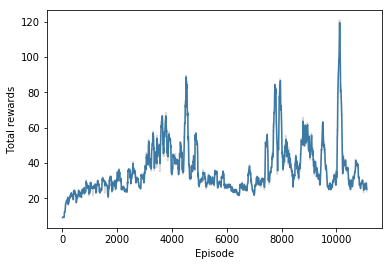

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

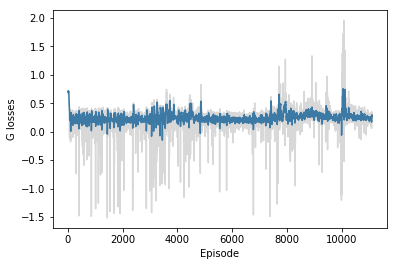

In [26]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

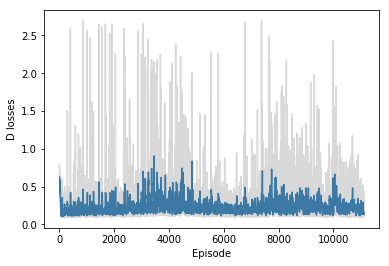

In [27]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.